<a href="https://colab.research.google.com/github/juanserrano90/codelatam/blob/main/Augmented_Data_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://github.com/juanserrano90/codelatam/blob/main/Training/ViT/Augmented_Data_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/juanserrano90/codelatam.git

Cloning into 'codelatam'...
remote: Enumerating objects: 14329, done.
remote: Counting objects: 100% (872/872), done.
remote: Compressing objects: 100% (866/866), done.
remote: Total 14329 (delta 41), reused 800 (delta 6), pack-reused 13457 (from 1)
Receiving objects: 100% (14329/14329), 209.80 MiB | 16.88 MiB/s, done.
Resolving deltas: 100% (312/312), done.
Updating files: 100% (26536/26536), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from collections import defaultdict
import re
import pickle
from pathlib import Path

# Read Data

In [ ]:
# read augmented_images folder and create a list of images for each subfolder
image_lists = {}
root_dir = 'codelatam/Data/augmented_images_v2'

for subdir, dirs, files in os.walk(root_dir):
  for file in files:
    if file.endswith(('.jpg', '.jpeg', '.png')):
      subdir_name = os.path.basename(subdir)
      if subdir_name not in image_lists:
        image_lists[subdir_name] = []
      # image_lists[subdir_name].append(os.path.join(subdir, file))
      image_lists[subdir_name].append(file)

# Print the list of images for each subfolder
sum_img = 0
for subdir_name, image_list in image_lists.items():
  sum_img += len(image_list)
  print(f"Subfolder: {subdir_name}, Number of images: {len(image_list)}")
  print(image_list)  # Uncomment to print the full list of images
print(f"Total number of images: {sum_img}")

Subfolder: 1, Number of images: 2385
['sn05gj_3_0_74.499_4432_COPY.png', 'sn91T_1_0_-6.4_3132.png', 'sn1999ac_1_0_33.6_3321_COPY.png', 'sn91bg_2_0_18.9_3152.png', 'sn1995bd_1_0_-12.0_2955.png', 'sn2002ic_3_0_31.9_4490_COPY.png', 'sn2008A_4_0_-7.9_4057_COPY.png', 'sn2005ke_2_0_31.2_2731.png', 'sn2007if_5_0_51.2_3687_COPY.png', 'sn1999da_2_0_-2.6_3127.png', 'sn99aa_1_0_-10.491_2903.png', 'sn1998es_1_0_72.7_2879.png', 'sn2007if_5_0_39.1_3625_COPY.png', 'sn05gj_3_0_48.113_4337_COPY.png', 'sn02cx_4_0_24.1_4211_COPY.png', 'sn2003fa_1_0_-9.5_2527.png', 'sn2001V_1_0_46.7_3312_COPY.png', 'sn05gj_3_0_48.113_4409_COPY.png', 'sn1999aa_1_0_-6.1_3359_COPY.png', 'sn1986G_2_0_45.2_3478_COPY.png', 'sn1998es_1_0_-0.5_2866.png', 'sn05hk_4_0_50.959_3951_COPY.png', 'sn2002cx_4_0_19.1_4046_COPY.png', 'sn2002ic_3_0_5.6_4370_COPY.png', 'sn2002ic_3_0_44.1_4390_COPY.png', 'sn1999aa_1_0_-0.2_2999.png', 'sn1998es_1_0_16.3_2870.png', 'sn1999gp_1_0_49.7_3306_COPY.png', 'sn2006gz_5_0_11.1_3904_COPY.png', 'sn2006gz_5

In [ ]:
def maping(a):
  subtype_to_category = {0:0, 1:1, 2:1, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:2, 10:2, 11:2, 12:2, 13:2, 14:2, 15:2, 16:2}
  return subtype_to_category[a]

inv_dict_mapping_classes = {0:'Ia-norm', 1:'Ia-pec', 2:'Others'}

# Checking augmented data

In [ ]:
# For each subfolder, separate the images that say COPY in their path from those that do not.
def separate_images_with_copy(images_by_subfolder):
  """
  Separates images in each subfolder based on whether 'COPY' is in their path.

  Args:
    images_by_subfolder: A dictionary where keys are subfolder names and values are lists of image paths.

  Returns:
    A dictionary with the same subfolder keys, but values are now dictionaries
    containing 'with_copy' and 'without_copy' lists of images.
  """
  separated_images = {}
  for subfolder, image_list in images_by_subfolder.items():
    with_copy = []
    without_copy = []
    for image_path in image_list:
      if 'COPY' in image_path:
        if subfolder == '1':  # FIX 1: there is a problem with the SN labeling
          str_list = image_path.split("_")
          with_copy.append("_".join(str_list[:-3])) # remove the copy counter and the .png string
        else:
          str_list = image_path.split("_")
          if any(ele in str_list[1] for ele in ['6', '8', '10', '11', '16']): # FIX 2: There are categories labeled as copies (even though they are not)
            without_copy.append("_".join(str_list[:-2]))
          else:
            with_copy.append("_".join(str_list[:-2])) # remove the copy counter and the .png string
      else:
        str_list = image_path.split("_")
        without_copy.append("_".join(str_list[:-1]))
    separated_images[subfolder] = {'with_copy': with_copy, 'without_copy': without_copy}
  return separated_images

separated_images = separate_images_with_copy(image_lists)

for subfolder, image_dict in separated_images.items():
  print(f"Subfolder: {subfolder}")
  print(f"  Copied images: {len(image_dict['with_copy'])}")
  # Uncomment to print the list of images with 'COPY'
  print(f"    Image list: {image_dict['with_copy']}")
  print(f"  Original images: {len(image_dict['without_copy'])}")
  # Uncomment to print the list of images without 'COPY'
  print(f"    Image list: {image_dict['without_copy']}")


Subfolder: 1
  Copied images: 1484
    Image list: ['sn05gj_3_0', 'sn1999ac_1_0', 'sn2002ic_3_0', 'sn2008A_4_0', 'sn2007if_5_0', 'sn2007if_5_0', 'sn05gj_3_0', 'sn02cx_4_0', 'sn2001V_1_0', 'sn05gj_3_0', 'sn1999aa_1_0', 'sn1986G_2_0', 'sn05hk_4_0', 'sn2002cx_4_0', 'sn2002ic_3_0', 'sn2002ic_3_0', 'sn1999gp_1_0', 'sn2006gz_5_0', 'sn2006hb_2_0', 'sn91T_1_0', 'sn00cx_5_0', 'sn00cx_5_0', 'sn2006gz_5_0', 'sn06ke_2_0', 'sn2005gj_3_0', 'sn2008A_4_0', 'sn2005hk_4_0', 'sn1991bg_2_0', 'sn2002ic_3_0', 'sn05gj_3_0', 'sn2000cx_5_0', 'sn05gj_3_0', 'sn2002es_2_0', 'sn2007if_5_0', 'sn02cx_4_0', 'sn2002cx_4_0', 'sn05hk_4_0', 'sn99by_2_0', 'sn2006hb_2_0', 'sn2002ic_3_0', 'sn2008A_4_0', 'sn2005hk_4_0', 'sn1998ab_1_0', 'sn2007if_5_0', 'sn2008A_4_0', 'sn2002cx_4_0', 'sn08A_4_0', 'sn2005gj_3_0', 'sn07ba_2_0', 'sn2008A_4_0', 'sn2005gj_3_0', 'sn05gj_3_0', 'sn2007if_5_0', 'sn05hk_4_0', 'sn00cx_5_0', 'sn2002ic_3_0', 'sn2005gj_3_0', 'sn2008A_4_0', 'sn2005gj_3_0', 'sn2005hk_4_0', 'sn2005gj_3_0', 'sn1999by_2_0', 'sn2

In [ ]:
# for each 'without_copy' string, count how many strings are repeated in 'with_copy'
import collections

count_dict = {}

for subfolder, image_dict in separated_images.items():
  without_copy_list = image_dict['without_copy']
  with_copy_list = image_dict['with_copy']

  for image_without_copy in without_copy_list:
    count = with_copy_list.count(image_without_copy)
    if image_without_copy not in count_dict:
      count_dict[image_without_copy] = count
    else:
      count_dict[image_without_copy] += count

# create a pandas dataframe using count_dict

df = pd.DataFrame(list(count_dict.items()), columns=['Image', 'Copies'])
df['Category'] = df['Image'].str.split('_').str[1]
print(df)


                   Image  Copies Category
0         sn91T_1_0_-6.4       0        1
1        sn91bg_2_0_18.9       0        2
2     sn1995bd_1_0_-12.0       0        1
3      sn2005ke_2_0_31.2       0        2
4      sn1999da_2_0_-2.6       0        2
...                  ...     ...      ...
4635   sn2002ao_7_1_28.3       4        7
4636  sn1999em_13_3_90.0       0       13
4637   sn2006jc_7_1_61.5       2        7
4638  sn2012ap_11_2_-1.0       0       11
4639  sn2007gr_10_2_17.0       0       10

[4640 rows x 3 columns]


In [ ]:
SNsubtype_original = {i: 0 for i in range(0, 17)}
SNsubtype_copies = {i: 0 for i in range(0, 17)}
SNsubtype_total = {i: 0 for i in range(0, 17)}
SNsubtype_uniquename = {i: 0 for i in range(0, 17)}
stypes_names = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[], 12:[], 13:[], 14:[], 15:[], 16:[]}

for subfolder, image_dict in separated_images.items():
  without_copy_list = image_dict['without_copy']
  with_copy_list = image_dict['with_copy']
  names = []

  for image_name in without_copy_list:
    if int(image_name.split('_')[1]) in SNsubtype_original:
      SNsubtype_original[int(image_name.split('_')[1])] += 1
    stypes_names[int(image_name.split('_')[1])].append(image_name.split('_')[0])

  for image_name in with_copy_list:
    if int(image_name.split('_')[1]) in SNsubtype_copies:
      SNsubtype_copies[int(image_name.split('_')[1])] += 1

  for key,value in SNsubtype_total.items():
    SNsubtype_total[key] = SNsubtype_original[key] + SNsubtype_copies[key]

for key, value in stypes_names.items():
  SNsubtype_uniquename[key] = len(set(value))

In [ ]:
# # convert SNsubtype_original, SNsubtype_copies and SNsubtype_total to a one pandas dataframe
# #   where the columns labels are N° originals, N° copies and N° total respectively
# #   and each row label is the key of the dictionary

id_to_subtype = {0: 'Ia-norm',
 1: 'Ia-91T',
 3: 'Ia-csm',
 2: 'Ia-91bg',
 6: 'Ib-norm',
 4: 'Iax',
 5: 'Ia-pec',
 10: 'Ic-norm',
 13: 'IIP',
 14: 'IIL',
 8: 'IIb',
 16: 'II-pec',
 11: 'Ic-broad',
 12: 'Ic-pec',
 15: 'IIn',
 7: 'Ibn',
 9: 'Ib-pec'}

# Create a list of dictionaries, where each dictionary represents a row
rows = []
for key in SNsubtype_original:
  row = {
      'N° originals': SNsubtype_original[key],
      'N° copies': SNsubtype_copies[key],
      'N° total': SNsubtype_total[key],
      'N° unique names': SNsubtype_uniquename[key],
  }
  rows.append(row)

# Create the DataFrame from the list of dictionaries
df = pd.DataFrame(rows, index=SNsubtype_original.keys())
df.index.name = "ID"
df['Category'] = df.index.map(maping)
df['Subtype'] = df.index.map(id_to_subtype)
df = df[['Category', 'Subtype', 'N° originals', 'N° copies', 'N° total', 'N° unique names']]
print(df)

    Category   Subtype  N° originals  N° copies  N° total  N° unique names
ID                                                                        
0          0   Ia-norm          2387          0      2387              319
1          1    Ia-91T           398         79       477               36
2          1   Ia-91bg           264        213       477               42
3          1    Ia-csm            30        447       477                3
4          1       Iax            68        409       477                7
5          1    Ia-pec           141        336       477                7
6          2   Ib-norm           217          0       217               21
7          2       Ibn            31        186       217                3
8          2       IIb           216          0       216               18
9          2    Ib-pec            15        202       217                2
10         2   Ic-norm           217          0       217               21
11         2  Ic-broad   

Images per-class

In [ ]:
# for each category, show the row sum of the column "N° total"
category_total = df.groupby('Category')['N° total'].sum()
print(category_total)

Category
0    2387
1    2385
2    2386
Name: N° total, dtype: int64


Unique SNs by class:

In [ ]:
# Dictionary to store base name counts and their subtypes for each subfolder
alld = dict()
for subfolder, images in image_lists.items():
    alld[subfolder] = defaultdict(lambda: {'count': 0, 'subtype': set()})
    for image in images:
        base_name = image.split('_')[0]
        subtype = image.split('_')[1]
        alld[subfolder][base_name]['count'] += 1
        alld[subfolder][base_name]['subtype'].add(subtype)

# Print the results for each class
for i in range(3):
    unique_sn_count = len(alld[str(i)].keys())
    print(f'Class {i}: {unique_sn_count} unique SNs')

Class 0: 319 unique SNs
Class 1: 95 unique SNs
Class 2: 102 unique SNs


This is why we can't balance subtype in train/test for class 2
(each subtype has 217 images)

In [ ]:
# Sort and print the top 10 base names by count for Class 2
class_2_data = alld['2']
sorted_class_2 = sorted(class_2_data.items(), key=lambda x: x[1]['count'], reverse=True)

print("Top 10 base names by count for Class 2:")
for base_name, data in sorted_class_2[:15]:
    print(f"{base_name}: Count = {data['count']}, Subtype = {data['subtype']}")

Top 10 base names by count for Class 2:
sn1987A: Count = 217, Subtype = {'16'}
sn1998S: Count = 195, Subtype = {'15'}
sn2004aw: Count = 169, Subtype = {'12'}
sn2007uy: Count = 157, Subtype = {'9'}
sn2006jc: Count = 141, Subtype = {'7'}
sn1980K: Count = 139, Subtype = {'14'}
sn1979C: Count = 78, Subtype = {'14'}
sn2005la: Count = 60, Subtype = {'9'}
sn2004et: Count = 56, Subtype = {'13'}
sn1999em: Count = 56, Subtype = {'13'}
sn2005cs: Count = 54, Subtype = {'13'}
sn2000er: Count = 50, Subtype = {'7'}
sn2005ek: Count = 48, Subtype = {'12'}
sn1993J: Count = 48, Subtype = {'8'}
sn2009jf: Count = 38, Subtype = {'6'}


In [ ]:
# Sort and print the top 10 base names by count for Class 1
class_1_data = alld['1']
sorted_class_1 = sorted(class_1_data.items(), key=lambda x: x[1]['count'], reverse=True)

print("Top 10 base names by count for Class 1:")
for base_name, data in sorted_class_1[:15]:
    print(f"{base_name}: Count = {data['count']}, Subtype = {data['subtype']}")

Top 10 base names by count for Class 1:
sn2005gj: Count = 224, Subtype = {'3'}
sn2002ic: Count = 157, Subtype = {'3'}
sn2008A: Count = 156, Subtype = {'4'}
sn2007if: Count = 154, Subtype = {'5'}
sn2005hk: Count = 126, Subtype = {'4'}
sn00cx: Count = 117, Subtype = {'5'}
sn05gj: Count = 96, Subtype = {'3'}
sn02cx: Count = 89, Subtype = {'4'}
sn2000cx: Count = 72, Subtype = {'5'}
sn2006gz: Count = 61, Subtype = {'5'}
sn91bg: Count = 60, Subtype = {'2'}
sn1986G: Count = 57, Subtype = {'2'}
sn2001V: Count = 48, Subtype = {'1'}
sn1999ac: Count = 44, Subtype = {'1'}
sn1999aa: Count = 44, Subtype = {'1'}


In [ ]:
# this SNs must be on train set (because they have too many images)
force_train = ['sn1987A', 'sn1998S', 'sn2004aw', 'sn2007uy', 'sn2006jc', 'sn1980K', 'sn1979C']

In [ ]:
suma = 0
for i in force_train:
  suma = suma + alld['2'][i]['count']
print(suma)

1096


How many images in image_lists:

In [ ]:
# count how many images are in image_lists
total_images = sum(len(images) for images in image_lists.values())
print(f"Total number of images: {total_images}")

Total number of images: 7158


# Holdout test data

In [ ]:
import random
import collections

# We split first train and test
def create_train_test_splits(image_lists, train_ratio=0.90, test_ratio=0.10, force_train=['sn1987A', 'sn1998S', 'sn2004aw', 'sn2007uy', 'sn2006jc', 'sn1980K', 'sn1979C'],
                             force_test=[]):
    """
    Creates train and test splits for images in each subfolder,
    ensuring that images with the same base name are not repeated across splits,
    and that at least one base name for each subtype is included in the test set for subfolder 1.
    Additionally, for subfolder 2, ensures specific base names go into the train set.

    Args:
        image_lists: A dictionary where keys are subfolder names and values are lists of image paths.
        train_ratio: The proportion of images to include in the training set.
        test_ratio: The proportion of images to include in the test set.

    Returns:
        A dictionary with subfolder names as keys and values as dictionaries containing 'train' and 'test' lists of images.
    """
    splits = {}
    subtypes = {}
    # Subtype mappings for subfolder 1
    subtype_ranges = {
        "0": [0],             # Subfolder 0 has subtype 0
        "1": list(range(1, 6)),  # Subfolder 1 has subtypes 1 to 5
        "2": list(range(6, 17))  # Subfolder 2 has subtypes 6 to 16
    }

    # Base names to force into train set for subfolder 2 for train/test ['sn1987A', 'sn1998S', 'sn2004aw', 'sn2007uy', 'sn2006jc', 'sn1980K', 'sn1979C']

    for subfolder, image_list in image_lists.items():
        # Shuffle the image list to randomize
        random.shuffle(image_list)

        # Extract subtype information for each image
        subtype_dict = collections.defaultdict(list)
        for image_path in image_list:
            subtype = int(image_path.split('_')[1])  # Extract subtype as an integer
            subtype_dict[subtype].append(image_path)

        train_images = set()
        test_images = set()
        base_names = {}
        assigned_subtypes = set()

        if subfolder == "1":
            # Step 1: Ensure at least one base name for each subtype in the test set for subfolder 1
            for subtype in subtype_ranges[subfolder]:
                if subtype in subtype_dict:
                    paths = subtype_dict[subtype]
                    random.shuffle(paths)  # Shuffle to ensure randomness
                    for path in paths:
                        base_name = path.split('_')[0]
                        if base_name not in base_names:
                            base_names[base_name] = 'test'
                            test_images.add(path)
                            assigned_subtypes.add(subtype)
                            break  # Stop once we've added one base name for this subtype

        # Step 2: Distribute remaining images into train and test sets
        for image_path in image_list:
            base_name = image_path.split('_')[0]

            # Ensure specific base names go into train set for subfolder 2
            if base_name in force_train:
                base_names[base_name] = 'train'
                train_images.add(image_path)
            elif base_name in force_test:
                base_names[base_name] = 'test'
                test_images.add(image_path)
            else:
              if base_name not in base_names:
                  if random.random() < train_ratio:
                      base_names[base_name] = 'train'
                      train_images.add(image_path)
                  else:
                      base_names[base_name] = 'test'
                      test_images.add(image_path)
              else:
                  # Add to the respective split based on the assigned base name
                  if base_names[base_name] == 'train':
                      train_images.add(image_path)
                  elif base_names[base_name] == 'test':
                      test_images.add(image_path)

        # Collect the subtypes for train and test splits
        train_subtypes = {int(image.split('_')[1]) for image in train_images}
        test_subtypes = {int(image.split('_')[1]) for image in test_images}

        splits[subfolder] = {'train': list(train_images), 'test': list(test_images)}
        subtypes[subfolder] = {'train': train_subtypes, 'test': test_subtypes}

    return splits, subtypes

In [ ]:
# # Keep trying splits until the ratios are within the tolerance.
# counter = 0
# while True:
#   splits, subtypes = create_train_test_splits(image_lists, train_ratio=0.90, test_ratio=0.10)
#   counter += 1
#   tolerance = 0.02
#   a = []
#   c = []
#   for i in range(3):
#     subtotal = len(splits[str(i)]['train'])+len(splits[str(i)]['test'])
#     a.append(round(len(splits[str(i)]['train'])/subtotal,2))
#     c.append(round(len(splits[str(i)]['test'])/subtotal,2))

#   if abs(a[0]-0.90) < tolerance and  abs(c[0]-0.10) < tolerance and abs(a[1]-0.90) < tolerance and \
#      abs(c[1]-0.10) < tolerance and abs(a[2]-0.90) < tolerance and abs(c[2]-0.10) < tolerance and \
#      6 in subtypes['2']['test'] and 8 in subtypes['2']['test'] and 10 in subtypes['2']['test'] and \
#      11 in subtypes['2']['test']:

#       good_split = splits
#       break

# # Print the number of images in each split for each subfolder
# print('iterations:', counter)
# for key, value in splits.items():
#   print(f"{key}: {value}")

In [ ]:
# # check the number of images in each split
# total = 0
# print('images per split:')
# for i in range(3):
#   print(len(splits[str(i)]['train']), len(splits[str(i)]['test']))
#   total += len(splits[str(i)]['train']) + len(splits[str(i)]['test'])
# print('----------------')
# print('total images:', total)
# # proportions
# print('----------------')
# print('proportions:')
# for i in range(3):
#   subtotal = len(splits[str(i)]['train'])+len(splits[str(i)]['test'])
#   print(round(len(splits[str(i)]['train'])/subtotal,2), round(len(splits[str(i)]['test'])/subtotal,2))

#   splits[str(i)]['test']

In [ ]:
# # Print the different subtypes in train and test for each subfolder
# for subfolder, subtype_info in subtypes.items():
#     print(f"Subfolder {subfolder}:")
#     print(f"  Train subtypes: {sorted(subtype_info['train'])}")
#     print(f"  Test subtypes: {sorted(subtype_info['test'])}")

In [ ]:
# save the dictionary to a file to recover the same split later (because it's random everytime)
# last split: 0.83, 0.86, 0.86, [6, 7, 8, 10, 11, 13, 15] saved_test_train_split.pkl
# last last split: 0.1, 0.09, 0.09 [6, 8, 10, 11, 12, 13] saved_test_train_split_nuevo.pkl

# with open('drive/MyDrive/lssds24/codelatam/saved_test_train_split_nuevo.pkl', 'wb') as f:
#     pickle.dump(splits, f)

In [ ]:
# load the saved split dictionary
# el archivo 'saved_splits.pkl' se puede cargar de mi google drive (juan)
# https://drive.google.com/drive/folders/1I9gk_JM-oFOD4xplydMrtrNrqHZeU0Jo?usp=sharing

# splits saved: [saved_test_train_split.pk, saved_test_train_split_nuevo.pk]
with open('drive/MyDrive/lssds24/codelatam/saved_test_train_split_nuevo.pkl', 'rb') as f:
    splits = pickle.load(f)

In [ ]:
subts = []
class_ = '2'
for image in splits[class_]['train']:
  subt = image.split('_')[1]
  if subt not in subts:
    subts.append(subt)
print(f'Class {class_} subtypes on train:', subts)
subts = []
for image in splits[class_]['test']:
  subt = image.split('_')[1]
  if subt not in subts:
    subts.append(subt)
print(f'Class {class_} ssubtypes on test:', subts)

Class 2 subtypes on train: ['16', '6', '11', '13', '15', '12', '9', '7', '14', '10', '8']
Class 2 ssubtypes on test: ['13', '12', '11', '10', '8', '6']


In [ ]:
# check the number of images in each split
total = 0
print('images per split:')
for i in range(3):
  print(len(splits[str(i)]['train']), len(splits[str(i)]['test']))
  total += len(splits[str(i)]['train']) + len(splits[str(i)]['test'])
print('----------------')
print('total images:', total)
# proportions
print('----------------')
print('proportions:')
for i in range(3):
  subtotal = len(splits[str(i)]['train'])+len(splits[str(i)]['test'])
  print(round(len(splits[str(i)]['train'])/subtotal,2), round(len(splits[str(i)]['test'])/subtotal,2))

  splits[str(i)]['test']

images per split:
2160 227
2168 217
2161 225
----------------
total images: 7158
----------------
proportions:
0.9 0.1
0.91 0.09
0.91 0.09


In [ ]:
# Subtypes count by split
subtype_counts_per_split = {}

for split_name in ['train', 'test']: # Assuming you have train and test splits
  subtype_counts_per_split[split_name] = {}
  for subfolder, data in splits.items():
    for image_name in data[split_name]:
      subtype = image_name.split('_')[1] # Extract subtype from filename
      if subtype not in subtype_counts_per_split[split_name]:
        subtype_counts_per_split[split_name][subtype] = 0
      subtype_counts_per_split[split_name][subtype] += 1

subtype_counts_per_split

{'train': {'4': 434,
  '3': 381,
  '2': 470,
  '1': 433,
  '5': 450,
  '0': 2160,
  '16': 217,
  '6': 200,
  '11': 177,
  '13': 163,
  '15': 217,
  '12': 169,
  '9': 217,
  '7': 217,
  '14': 217,
  '10': 172,
  '8': 195},
 'test': {'4': 43,
  '3': 96,
  '1': 44,
  '5': 27,
  '2': 7,
  '0': 227,
  '13': 54,
  '12': 48,
  '11': 40,
  '10': 45,
  '8': 21,
  '6': 17}}

In [ ]:
# check if there are base names repeated in train and test in splits

def check_repeated_basenames(splits):
  """
  Checks for repeated base names in the train and test splits.

  Args:
    splits: A dictionary containing the train and test splits.

  Returns:
    A dictionary where keys are subfolder names and values are lists of
    repeated base names.
  """
  repeated_basenames = {}
  for subfolder, data in splits.items():
      train_basenames = set()
      test_basenames = set()
      repeated = []

      for image_name in data['train']:
          base_name = image_name.split('_')[0]
          train_basenames.add(base_name)

      for image_name in data['test']:
          base_name = image_name.split('_')[0]
          if base_name in train_basenames:
              repeated.append(base_name)
          test_basenames.add(base_name)

      repeated_basenames[subfolder] = repeated
  return repeated_basenames


repeated_names = check_repeated_basenames(splits)

# Print the repeated base names for each subfolder
if repeated_names == {}:
  print('No repeated base names')
else:
  for subfolder, names in repeated_names.items():
    print(f"Subfolder: {subfolder}, Repeated base names: {names}")

Subfolder: 1, Repeated base names: []
Subfolder: 0, Repeated base names: []
Subfolder: 2, Repeated base names: []


# Create train/val splits

In [ ]:
train_split = {'0':splits['0']['train'], '1':splits['1']['train'] , '2':splits['2']['train']}

In [ ]:
# Dictionary to store base name counts and their subtypes for each subfolder
alld2 = dict()
for subfolder, images in train_split.items():
    alld2[subfolder] = defaultdict(lambda: {'count': 0, 'subtype': set()})
    for image in images:
        base_name = image.split('_')[0]
        subtype = image.split('_')[1]
        alld2[subfolder][base_name]['count'] += 1
        alld2[subfolder][base_name]['subtype'].add(subtype)

# Print the results for each class
for i in range(3):
    unique_sn_count = len(alld2[str(i)].keys())
    print(f'Class {i}: {unique_sn_count} unique SNs')

Class 0: 288 unique SNs
Class 1: 87 unique SNs
Class 2: 88 unique SNs


In [ ]:
# Sort and print the top 10 base names by count for Class 1
class_1_data = alld2['1']
sorted_class_1 = sorted(class_1_data.items(), key=lambda x: x[1]['count'], reverse=True)

print("Top 10 base names by count for Class 1:")
for base_name, data in sorted_class_1[:10]:
    print(f"{base_name}: Count = {data['count']}, Subtype = {data['subtype']}")

Top 10 base names by count for Class 1:
sn2005gj: Count = 224, Subtype = {'3'}
sn2002ic: Count = 157, Subtype = {'3'}
sn2008A: Count = 156, Subtype = {'4'}
sn2007if: Count = 154, Subtype = {'5'}
sn2005hk: Count = 126, Subtype = {'4'}
sn00cx: Count = 117, Subtype = {'5'}
sn02cx: Count = 89, Subtype = {'4'}
sn2000cx: Count = 72, Subtype = {'5'}
sn2006gz: Count = 61, Subtype = {'5'}
sn91bg: Count = 60, Subtype = {'2'}


In [ ]:
# Sort and print the top 10 base names by count for Class 1
class_2_data = alld2['2']
sorted_class_2 = sorted(class_2_data.items(), key=lambda x: x[1]['count'], reverse=True)

print("Top 10 base names by count for Class 2:")
for base_name, data in sorted_class_2[:10]:
    print(f"{base_name}: Count = {data['count']}, Subtype = {data['subtype']}")

Top 10 base names by count for Class 2:
sn1987A: Count = 217, Subtype = {'16'}
sn1998S: Count = 195, Subtype = {'15'}
sn2004aw: Count = 169, Subtype = {'12'}
sn2007uy: Count = 157, Subtype = {'9'}
sn2006jc: Count = 141, Subtype = {'7'}
sn1980K: Count = 139, Subtype = {'14'}
sn1979C: Count = 78, Subtype = {'14'}
sn2005la: Count = 60, Subtype = {'9'}
sn2004et: Count = 56, Subtype = {'13'}
sn1999em: Count = 56, Subtype = {'13'}


In [ ]:
# # we can use the same function as before, but the input data should be only the train sets
# splits_train = {'0':splits['0']['train'], '1':splits['1']['train'] , '2':splits['2']['train']}

# force_train_val = ['sn1987A', 'sn1998S', 'sn2004aw', 'sn2007uy', 'sn2005gj', 'sn2002ic', 'sn2008A', 'sn2007if']

In [ ]:
# # Keep trying splits until the ratios are within the tolerance.
# counter = 0
# while True:
#   splits_2, subtypes_2 = create_train_test_splits(splits_train, train_ratio=0.834, test_ratio=0.166, force_train=force_train_val)
#   counter += 1
#   tolerance = 0.01
#   a = []
#   c = []
#   for i in range(3):
#     subtotal = len(splits_2[str(i)]['train'])+len(splits_2[str(i)]['test'])
#     a.append(round(len(splits_2[str(i)]['train'])/subtotal,2))
#     c.append(round(len(splits_2[str(i)]['test'])/subtotal,2))

#   if abs(a[0]-0.834) < tolerance and  abs(c[0]-0.166) < tolerance and abs(a[1]-0.834) < tolerance and \
#      abs(c[1]-0.166) < tolerance and abs(a[2]-0.834) < tolerance and abs(c[2]-0.166) < tolerance and \
#      6 in subtypes['2']['test'] and 8 in subtypes['2']['test'] and 10 in subtypes['2']['test'] and \
#      11 in subtypes['2']['test']:

#       good_split = splits_2
#       break

# # Print the number of images in each split for each subfolder
# print('iterations:', counter)
# for key, value in splits_2.items():
#   print(f"{key}: {value}")

In [ ]:
# # # check the number of images in each split
# total = 0
# print('images per split:')
# for i in range(3):
#   print(len(splits_2[str(i)]['train']), len(splits_2[str(i)]['test']))
#   total += len(splits_2[str(i)]['train']) + len(splits_2[str(i)]['test'])
# print('----------------')
# print('total images:', total)
# # proportions
# print('----------------')
# print('proportions:')
# for i in range(3):
#   subtotal = len(splits_2[str(i)]['train'])+len(splits_2[str(i)]['test'])
#   print(round(len(splits_2[str(i)]['train'])/subtotal,3), round(len(splits_2[str(i)]['test'])/subtotal,3))

#   splits_2[str(i)]['test']

In [ ]:
# # Print the different subtypes in train and test for each subfolder
# for subfolder, subtype_info in subtypes_2.items():
#     print(f"Subfolder {subfolder}:")
#     print(f"  Train subtypes: {sorted(subtype_info['train'])}")
#     print(f"  Test subtypes: {sorted(subtype_info['test'])}")

In [ ]:
# # save the train_val split
# with open('drive/MyDrive/lssds24/codelatam/saved_train_val_split_nuevo_nuevo4.pkl', 'wb') as f:
#     pickle.dump(splits_2, f)

# load train_val split
# with open('drive/MyDrive/lssds24/codelatam/saved_train_val_split_nuevo_nuevo4.pkl', 'rb') as f:
#     splits_2 = pickle.load(f)

# Load train/val/test splits

In [ ]:
# final_split = {'0':{'train':splits_2['0']['train'], 'val':splits_2['0']['test'], 'test':splits['0']['test']},
#                 '1':{'train':splits_2['1']['train'], 'val':splits_2['1']['test'], 'test':splits['1']['test']},
#                 '2':{'train':splits_2['2']['train'], 'val':splits_2['2']['test'], 'test':splits['2']['test']}}

# for i in range(3):
#   print(f'class {i}:')
#   print('train:', len(final_split[str(i)]['train']), 'val:', len(final_split[str(i)]['val']), 'test:', len(final_split[str(i)]['test']),
#         '-- total:', len(final_split[str(i)]['train'])+len(final_split[str(i)]['val'])+len(final_split[str(i)]['test']))

In [ ]:
# # save the final train_val_test splits
# with open('drive/MyDrive/lssds24/codelatam/saved_train_val_test_split_nuevo_nuevo4.pkl', 'wb') as f:
#     pickle.dump(final_split, f)

# load complete split
with open('drive/MyDrive/lssds24/codelatam/saved_train_val_test_split_nuevo_nuevo4.pkl', 'rb') as f:
    splits = pickle.load(f)

In [ ]:
# lets check the repeated images between the three train/val splits:
tv_splits = {}
tv_filenames = ['drive/MyDrive/lssds24/codelatam/saved_train_val_test_split_nuevo_nuevo1.pkl',
                'drive/MyDrive/lssds24/codelatam/saved_train_val_test_split_nuevo_nuevo2.pkl',
                'drive/MyDrive/lssds24/codelatam/saved_train_val_test_split_nuevo_nuevo3.pkl',
                'drive/MyDrive/lssds24/codelatam/saved_train_val_test_split_nuevo_nuevo4.pkl']

for n, f in enumerate(tv_filenames):
  with open(f, 'rb') as file:
    tv_splits[f'{n+1}'] = pickle.load(file)

tv_splits.keys()

dict_keys(['1', '2', '3', '4'])

In [ ]:
def check_val_repeated_basenames(split1, split2):
  """
  Checks for repeated base names in diff val splits.
  Args:
    split1 (int): the first split to compare
    split2 (int): the first split to compare
  """
  to_check = {'0':{'train':tv_splits[str(split1)]['0']['val'], 'test':tv_splits[str(split2)]['0']['val']},
            '1':{'train':tv_splits[str(split1)]['1']['val'], 'test':tv_splits[str(split2)]['1']['val']},
            '2':{'train':tv_splits[str(split1)]['2']['val'], 'test':tv_splits[str(split2)]['2']['val']}}
  repeated_names = check_repeated_basenames(to_check)
  avg_val_length = (len(tv_splits[str(split1)]['0']['val']) + len(tv_splits[str(split2)]['0']['val']) + len(tv_splits[str(split1)]['1']['val']) + len(tv_splits[str(split2)]['1']['val']) + len(tv_splits[str(split1)]['2']['val']) + len(tv_splits[str(split2)]['2']['val']))/6

  # Print the repeated base names for each subfolder
  if repeated_names == {}:
    print('No repeated base names')
  else:
    for subfolder, names in repeated_names.items():
      print(f"Subfolder: {subfolder}, Repeated base names: {len(names)/avg_val_length}")

In all cases the proportion of repeated images is < 35%

In [ ]:
check_val_repeated_basenames(1,2)

Subfolder: 0, Repeated base names: 0.18072289156626506
Subfolder: 1, Repeated base names: 0.0027803521779425394
Subfolder: 2, Repeated base names: 0.09731232622798887


In [ ]:
check_val_repeated_basenames(1,3)

Subfolder: 0, Repeated base names: 0.19336758524054182
Subfolder: 1, Repeated base names: 0.050443717888836996
Subfolder: 2, Repeated base names: 0.19897244278374593


In [ ]:
check_val_repeated_basenames(1,4)

Subfolder: 0, Repeated base names: 0.35671156525777986
Subfolder: 1, Repeated base names: 0.2508128193218765
Subfolder: 2, Repeated base names: 0.29818857408267535


In [ ]:
check_val_repeated_basenames(2,3)

Subfolder: 0, Repeated base names: 0.12160294795025335
Subfolder: 1, Repeated base names: 0.03592814371257485
Subfolder: 2, Repeated base names: 0.2238599723629664


In [ ]:
check_val_repeated_basenames(2,4)

Subfolder: 0, Repeated base names: 0.12643151626202476
Subfolder: 1, Repeated base names: 0.22262940907008705
Subfolder: 2, Repeated base names: 0.1896472743930371


In [ ]:
check_val_repeated_basenames(3,4)

Subfolder: 0, Repeated base names: 0.22437673130193905
Subfolder: 1, Repeated base names: 0.14681440443213298
Subfolder: 2, Repeated base names: 0.34349030470914127


# Prepare data for modeling

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
from torchvision.io import read_image, ImageReadMode

def extract_data_from_splits(splits, root_dir):
    data = {'train': [], 'val': [], 'test': []}

    for subfolder, split_dict in splits.items():
        for split, image_list in split_dict.items():
            for image_name in image_list:
                image_path = os.path.join(root_dir, subfolder, image_name)
                label = maping(int(image_name.split('_')[1]))
                image_id = image_name[:-4]
                data[split].append((image_path, image_id, label))

    return data['train'], data['val'], data['test']

class CustomDataset(Dataset):
    def __init__(self, data):
        """
        data: list of tuples (image_path, id, label)
        """
        self.image_paths = [d[0] for d in data]
        self.ids = [d[1] for d in data]
        self.labels = [d[2] for d in data]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = read_image(self.image_paths[idx], mode=ImageReadMode.RGB).float()
        label = torch.tensor(self.labels[idx]).long()
        return {
            'id': self.ids[idx],
            'pixel_values': image,
            'y_true': label
        }

In [ ]:
# create custom datasets, don't load actual pixel values into memory yet.
train_data, val_data, test_data = extract_data_from_splits(splits, root_dir)

train_dataset = CustomDataset(train_data)
val_dataset = CustomDataset(val_data)
test_dataset = CustomDataset(test_data)

# Finetuning ViT

## Load pretrained model

In [ ]:
import torch.nn as nn
from transformers import ViTImageProcessor, ViTModel
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

num_classes = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pt_model_name = 'google/vit-base-patch32-224-in21k'
processor = ViTImageProcessor.from_pretrained(pt_model_name)
# model = ViTModel.from_pretrained(pt_model_name).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
# define model and clf head with a function

def load_model_and_classifier(dropout):

    model = ViTModel.from_pretrained(pt_model_name).to(device)

    classifier = nn.Sequential(
        nn.Linear(model.config.hidden_size, 512),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(256, num_classes)
    ).to(device)

    return model, classifier

## Define train/validate/predict steps

In [ ]:
def train_step(batch_data, model, processor, classifier, optimizer, device):
    model.train()
    y_true = batch_data['y_true'].to(device)

    inputs = processor(images=batch_data['pixel_values'], return_tensors="pt").to(device)
    outputs = model(**inputs)
    pooled_output = outputs.last_hidden_state[:, 0, :]

    logits = classifier(pooled_output)
    loss = F.cross_entropy(logits, y_true)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred = torch.argmax(logits, dim=-1)
    return loss.item(), y_pred, y_true


def validate_step(batch_data, model, processor, classifier, device):
    model.eval()
    with torch.no_grad():
        y_true = batch_data['y_true'].to(device)

        inputs = processor(images=batch_data['pixel_values'], return_tensors="pt").to(device)
        outputs = model(**inputs)
        pooled_output = outputs.last_hidden_state[:, 0, :]

        logits = classifier(pooled_output)
        loss = F.cross_entropy(logits, y_true)

        y_pred = torch.argmax(logits, dim=-1)
        return loss.item(), y_pred, y_true


def predict_step(batch_data, model, processor, classifier, device):
    model.eval()
    with torch.no_grad():
        y_true = batch_data['y_true'].to(device)

        inputs = processor(images=batch_data['pixel_values'], return_tensors="pt").to(device)
        outputs = model(**inputs)
        pooled_output = outputs.last_hidden_state[:, 0, :]

        logits = classifier(pooled_output)
        y_pred_prob = F.softmax(logits, dim=1)
        y_pred = torch.argmax(logits, dim=-1)

        return {
            'id': batch_data['id'],
            'y_pred': y_pred.cpu().numpy(),
            'y_pred_prob': y_pred_prob.cpu().numpy(),
            'y_true': y_true.cpu().numpy()
        }

## Train model

### Optuna?

In [ ]:
# !pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 17.4 MB/s eta 0:00:00


In [ ]:
# def objective(trial):
#   # Sample hyperparameters
#   lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
#   dropout = trial.suggest_uniform("dropout", 0.1, 0.9)
#   wd = trial.suggest_loguniform("wd", 1e-6, 1e-1)
#   batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

#   patience = 5
#   epochs = 100
#   val_losses_across_splits = []

#   for i in ['1', '2', '3']:
#     with open(f'drive/MyDrive/lssds24/codelatam/saved_train_val_test_split_nuevo_nuevo{i}.pkl', 'rb') as f:
#       splits = pickle.load(f)

#       train_data, val_data, test_data = extract_data_from_splits(splits, root_dir)
#       train_dataset = CustomDataset(train_data)
#       val_dataset = CustomDataset(val_data)
#       test_dataset = CustomDataset(test_data)

#     seed = 10
#     np.random.seed(seed)
#     random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     generator = torch.Generator()
#     generator.manual_seed(seed)

#     model, classifier = load_model_and_classifier(dropout)
#     params = list(model.parameters()) + list(classifier.parameters())
#     optimizer = AdamW(params, lr=lr, weight_decay=wd)

#     train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
#     val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

#     best_val_loss = float('inf')
#     patience_counter = 0

#     for epoch in range(epochs):
#       print('------------------------------------------------------------------------------------------------')
#       print('------------------------------------------------------------------------------------------------')
#       print(f"Training with learning rate={lr}, dropout={dropout}, batch size={batch_size}, weight decay={wd}")

#       for batch_data in train_dataloader:
#         loss, y_pred, y_true = train_step(batch_data, model, processor, classifier, optimizer, device)

#       val_losses = []
#       with torch.no_grad():
#         for batch_data in val_dataloader:
#           loss, y_pred, y_true = validate_step(batch_data, model, processor, classifier, device)
#           val_losses.append(loss)

#       val_loss = np.mean(val_losses)

#       if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         patience_counter = 0
#       else:
#         patience_counter += 1

#       if patience_counter >= patience:
#         break

#     del train_dataloader, val_dataloader, classifier, optimizer, model
#     val_losses_across_splits.append(best_val_loss)

#   # Average validation loss across all splits
#   avg_val_loss = np.mean(val_losses_across_splits)
#   return avg_val_loss

In [ ]:
# import optuna

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=10)  # You can increase trials for better results

# print("Best hyperparameters:")
# print(study.best_trial.params)

[I 2025-08-05 19:21:36,388] A new study created in memory with name: no-name-990c3e69-5396-475f-b339-0052fe5909f2
/tmp/ipython-input-1036977694.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
/tmp/ipython-input-1036977694.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform("dropout", 0.1, 0.9)
/tmp/ipython-input-1036977694.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform("wd", 1e-6, 1e-1)


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
Training with learning rate=3.330558676797262e-05, dropout=0.6363510042091242, batch size=32, weight decay=9.45217938674836e-05
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
Training with learning rate=3.330558676797262e-05, dropout=0.6363510042091242, batch size=32, weight decay=9.45217938674836e-05
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
Training with learning rate=3.330558676797262e-05, dropout=0.6363510042091242, batch size=32, weight decay=9.45217938674836e-05
----------------------------------

[W 2025-08-05 19:25:55,627] Trial 0 failed with parameters: {'lr': 3.330558676797262e-05, 'dropout': 0.6363510042091242, 'wd': 9.45217938674836e-05, 'batch_size': 32} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-1036977694.py", line 48, in objective
    loss, y_pred, y_true = train_step(batch_data, model, processor, classifier, optimizer, device)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2631396818.py", line 17, in train_step
    return loss.item(), y_pred, y_true
           ^^^^^^^^^^^
KeyboardInterrupt
[W 2025-08-05 19:25:55,628] Trial 0 failed with value None.


KeyboardInterrupt: 

### Gridsearch and Train

In [ ]:
# Define search ranges

# learning_rates = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4]
# dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# batch_sizes = [16, 32, 64]
# weight_decays = [1e-4, 1e-3, 1e-2, 1e-1]

# search_dict = {}

In [ ]:
# Frist I search the best lr and batch size using a dropout of 0.3 and wd of 1e-4
# for three different splits of test/val/test
# choose batch_size=64 and lr=1e-4
# choose wd = 1e-3
# choose dropout = 0.3
# fine tuned params:
batch_size = 64
lr = 1e-4
wd = 1e-3
dropout = 0.3

plots_dict = {}
epochs = 100
patience = 7

# # hyperparameter grid search
# for dropout in dropout_rates:
print('------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------')
print(f"Training with learning rate={lr}, dropout={dropout}, batch size={batch_size}, weight decay={wd}")

# this is for reproducibility ----------
seed = 10
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
generator = torch.Generator()
generator.manual_seed(seed)
# ---------------------------------------

# load model and classifier
model, classifier = load_model_and_classifier(dropout)

# load datasets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

params = list(model.parameters()) + list(classifier.parameters())
optimizer = AdamW(params, lr=lr, weight_decay=wd)

# save for ploting
t_loss = []
t_acc = []
t_f1 = []
v_loss = []
v_acc = []
v_f1 = []

best_val_loss = float('inf')
best_model_state = None
patience_counter = 0

for epoch in range(epochs):
  train_losses = []
  train_y_true = []
  train_y_pred = []

  for batch_data in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}"):
    loss, y_pred, y_true = train_step(batch_data, model, processor, classifier, optimizer, device)
    train_losses.append(loss)
    train_y_true.extend(y_true.cpu().numpy())
    train_y_pred.extend(y_pred.cpu().numpy())

  train_loss = np.mean(train_losses)
  train_acc = accuracy_score(train_y_true, train_y_pred)
  train_f1 = f1_score(train_y_true, train_y_pred, average='macro')

  val_losses = []
  val_y_true = []
  val_y_pred = []

  for batch_data in val_dataloader:
    loss, y_pred, y_true = validate_step(batch_data, model, processor, classifier, device)
    val_losses.append(loss)
    val_y_true.extend(y_true.cpu().numpy())
    val_y_pred.extend(y_pred.cpu().numpy())

  val_loss = np.mean(val_losses)
  val_acc = accuracy_score(val_y_true, val_y_pred)
  val_f1 = f1_score(val_y_true, val_y_pred, average='macro')

  t_loss.append(train_loss)
  t_acc.append(train_acc)
  t_f1.append(train_f1)
  v_loss.append(val_loss)
  v_acc.append(val_acc)
  v_f1.append(val_f1)
  print(f"Epoch {epoch + 1}/{epochs}")
  print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train F1: {train_f1:.4f}")
  print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}")

  if val_loss < best_val_loss:
    best_val_loss = val_loss
    patience_counter = 0
    best_model_state = {
        'model': model.state_dict(),
        'classifier': classifier.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch
    }
  else:
    patience_counter += 1

  if patience_counter >= patience:
    print(f"Early stopping triggered. No improvement in validation loss for {patience} epochs.")
    break

plots_dict[f"lr_{lr}_dropout_{dropout}_batch_size={batch_size}_wd_{wd}"] = [t_loss, t_acc, t_f1, v_loss, v_acc, v_f1]

# search_dict[f"lr_{lr}_dropout_{dropout}_batch_size={batch_size}_wd_{wd}"] = {
#       'train_loss': t_loss,
#       'train_acc': t_acc,
#       'train_f1': t_f1,
#       'val_loss': v_loss,
#       'val_acc': v_acc,
#       'val_f1': v_f1}

# del train_dataloader, val_dataloader, test_dataloader, classifier, optimizer, model

# torch.save(best_model_state, 'drive/MyDrive/lssds24/codelatam/v2_results/new_run/best_model_split4_64_1e4_1e3_03.pth')

------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
Training with learning rate=0.0001, dropout=0.3, batch size=64, weight decay=0.001


Epoch 1/100: 100%|██████████| 85/85 [01:20<00:00,  1.05it/s]


Epoch 1/100
Train Loss: 0.6838, Train Accuracy: 0.7453, Train F1: 0.7393
Val Loss: 0.7491, Val Accuracy: 0.6758, Val F1: 0.6667


Epoch 2/100: 100%|██████████| 85/85 [01:19<00:00,  1.07it/s]


Epoch 2/100
Train Loss: 0.2134, Train Accuracy: 0.9247, Train F1: 0.9244
Val Loss: 0.4801, Val Accuracy: 0.7989, Val F1: 0.7986


Epoch 3/100: 100%|██████████| 85/85 [01:13<00:00,  1.16it/s]


Epoch 3/100
Train Loss: 0.0908, Train Accuracy: 0.9682, Train F1: 0.9681
Val Loss: 0.6283, Val Accuracy: 0.7989, Val F1: 0.7936


Epoch 4/100: 100%|██████████| 85/85 [01:13<00:00,  1.16it/s]


Epoch 4/100
Train Loss: 0.0563, Train Accuracy: 0.9815, Train F1: 0.9815
Val Loss: 0.8042, Val Accuracy: 0.7943, Val F1: 0.7886


Epoch 5/100: 100%|██████████| 85/85 [01:13<00:00,  1.16it/s]


Epoch 5/100
Train Loss: 0.0445, Train Accuracy: 0.9848, Train F1: 0.9848
Val Loss: 0.8993, Val Accuracy: 0.7713, Val F1: 0.7734


Epoch 6/100: 100%|██████████| 85/85 [01:13<00:00,  1.16it/s]


Epoch 6/100
Train Loss: 0.0258, Train Accuracy: 0.9930, Train F1: 0.9930
Val Loss: 0.9132, Val Accuracy: 0.8108, Val F1: 0.8104


Epoch 7/100: 100%|██████████| 85/85 [01:13<00:00,  1.16it/s]


Epoch 7/100
Train Loss: 0.0168, Train Accuracy: 0.9944, Train F1: 0.9944
Val Loss: 1.1562, Val Accuracy: 0.7668, Val F1: 0.7651


Epoch 8/100: 100%|██████████| 85/85 [01:13<00:00,  1.15it/s]


Epoch 8/100
Train Loss: 0.0183, Train Accuracy: 0.9954, Train F1: 0.9954
Val Loss: 0.7307, Val Accuracy: 0.8209, Val F1: 0.8221


Epoch 9/100: 100%|██████████| 85/85 [01:13<00:00,  1.15it/s]


Epoch 9/100
Train Loss: 0.0180, Train Accuracy: 0.9944, Train F1: 0.9944
Val Loss: 0.9803, Val Accuracy: 0.7906, Val F1: 0.7843
Early stopping triggered. No improvement in validation loss for 7 epochs.


In [ ]:
# save search results
# with open('drive/MyDrive/lssds24/codelatam/v2_results/new_run/saved_search_results_dropout3_64_1e4_1e3.pkl', 'wb') as f:
#     pickle.dump(search_dict, f)

In [ ]:
# save dict of the last run for ploting
# with open('drive/MyDrive/lssds24/codelatam/v2_results/new_run/plot_results_split4_64_1e4_1e3_03.pkl', 'wb') as f:
#     pickle.dump(plots_dict, f)

## Search Results

In [ ]:
cmap = mpl.colormaps['tab20']

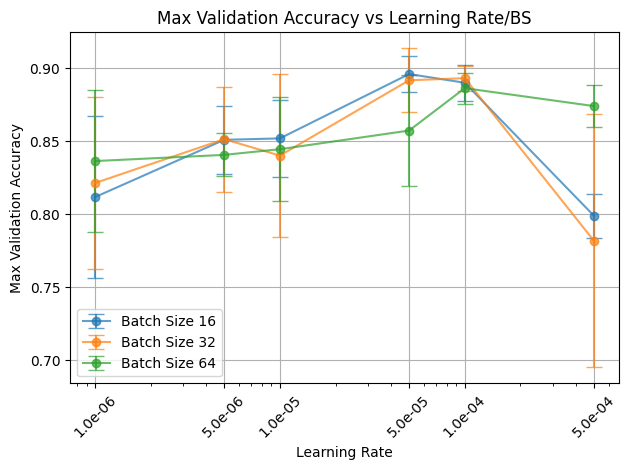

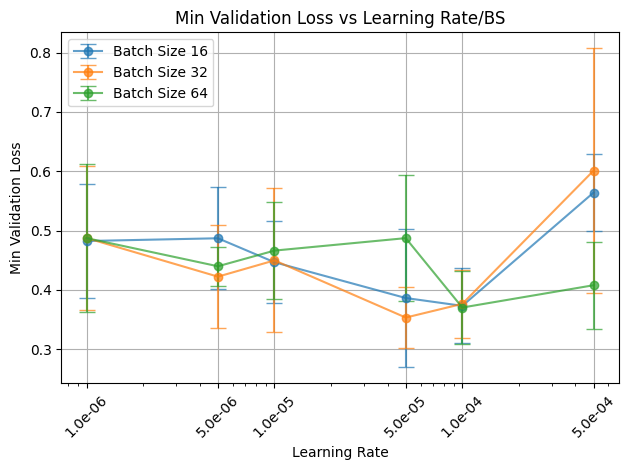

In [ ]:
# Load the search results from the pickle file
files = ['drive/MyDrive/lssds24/codelatam/v2_results/new_run/saved_search_results1.pkl',
         'drive/MyDrive/lssds24/codelatam/v2_results/new_run/saved_search_results2.pkl',
         'drive/MyDrive/lssds24/codelatam/v2_results/new_run/saved_search_results3.pkl']

search_results = []
for file in files:
    with open(file, 'rb') as f:
        search_results.append(pickle.load(f))

# Combine dictionaries
all_dicts = [search_results[0], search_results[1], search_results[2]]
data = defaultdict(list)
data_loss = defaultdict(list)

# Extract relevant information
for d in all_dicts:
    for key, accuracies in d.items():
        # Extract learning rate and batch size
        match = re.search(r'lr_([\de.-]+)_.*_batch_size=(\d+)_.*', key)
        if match:
            lr = float(match.group(1))
            batch_size = int(match.group(2))
            # Corrected line: Access 'val_acc' and then find the maximum.
            max_accuracy = max(accuracies['val_acc'])
            data[batch_size].append((lr, max_accuracy))

            min_loss = min(accuracies['val_loss'])
            data_loss[batch_size].append((lr, min_loss))

# Process data for plotting
plot_data = {}
for batch_size, values in data.items():
    lr_to_accuracies = defaultdict(list)
    for lr, acc in values:
        lr_to_accuracies[lr].append(acc)
    means = {lr: np.mean(accs) for lr, accs in lr_to_accuracies.items()}
    stds = {lr: np.std(accs) for lr, accs in lr_to_accuracies.items()}
    plot_data[batch_size] = (list(means.keys()), list(means.values()), list(stds.values()))

plot_data_loss = {}
for batch_size, values in data_loss.items():
    lr_to_losses = defaultdict(list)
    for lr, loss in values:
        lr_to_losses[lr].append(loss)
    means_loss = {lr: np.mean(loss) for lr, loss in lr_to_losses.items()}
    stds_loss = {lr: np.std(loss) for lr, loss in lr_to_losses.items()}
    plot_data_loss[batch_size] = (list(means_loss.keys()), list(means_loss.values()), list(stds_loss.values()))

for batch_size, (lrs, means, stds) in plot_data.items():
    plt.errorbar(lrs, means, yerr=stds, label=f'Batch Size {batch_size}', fmt='o-', capsize=6, alpha=0.7)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Max Validation Accuracy')
plt.title('Max Validation Accuracy vs Learning Rate/BS')
plt.legend()
plt.grid(True)
plt.xticks(learning_rates, labels=[f'{lr:.1e}' for lr in learning_rates], rotation=45)

plt.tight_layout()
plt.savefig('drive/MyDrive/lssds24/codelatam/v2_results/new_run/max_val_acc_vs_lr_and_bs_3splits.png', dpi=200, bbox_inches='tight')
plt.show()
for batch_size, (lrs, means, stds) in plot_data_loss.items():
    plt.errorbar(lrs, means, yerr=stds, label=f'Batch Size {batch_size}', fmt='o-', capsize=6, alpha=0.7)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Min Validation Loss')
plt.title('Min Validation Loss vs Learning Rate/BS')
plt.legend()
plt.grid(True)
plt.xticks(learning_rates, labels=[f'{lr:.1e}' for lr in learning_rates], rotation=45)

plt.tight_layout()
plt.savefig('drive/MyDrive/lssds24/codelatam/v2_results/new_run/min_val_loss_vs_lr_and_bs_3splits.png', dpi=200, bbox_inches='tight')
plt.show()

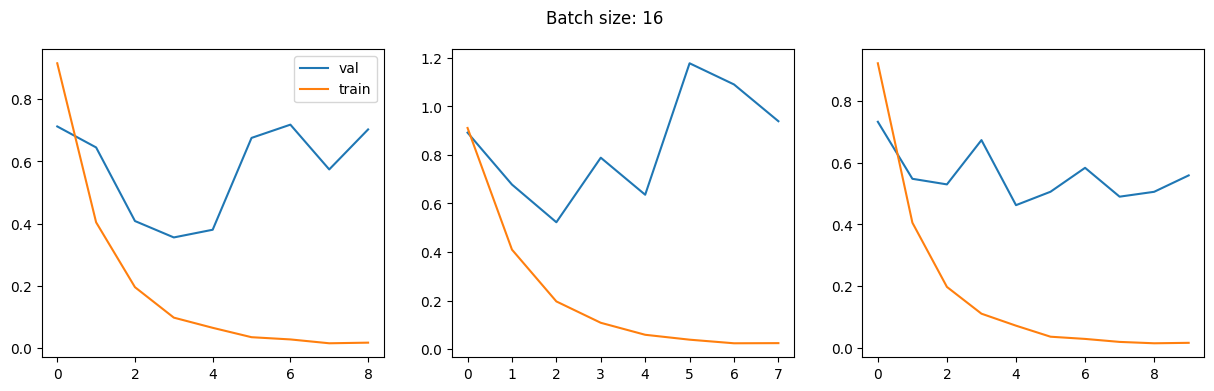

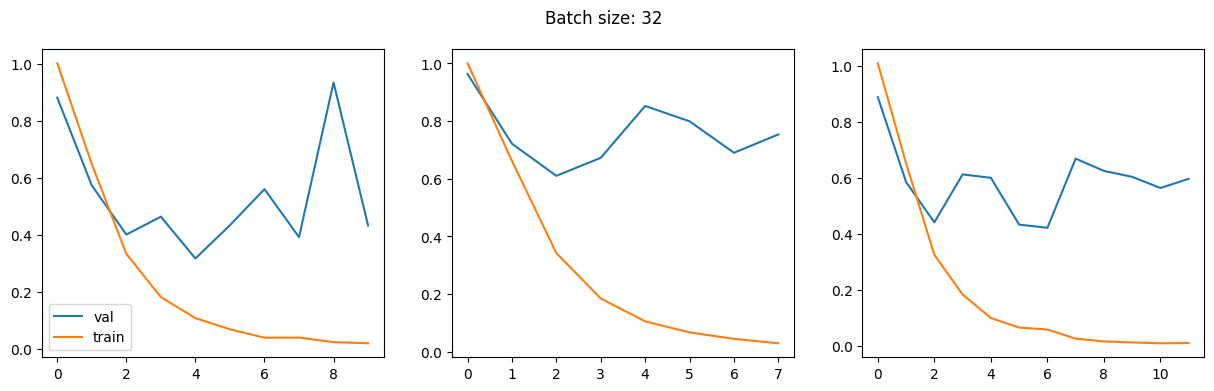

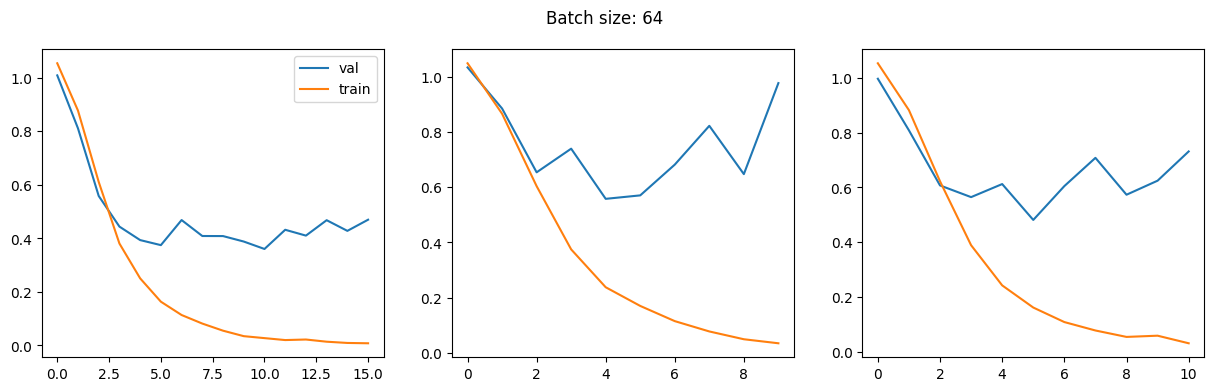

In [ ]:
for bs in batch_sizes:
  fig, axs = plt.subplots(1, 3, figsize=(15, 4))
  fig.suptitle(f'Batch size: {bs}')
  axs[0].plot(search_results[0][f'lr_1e-05_dropout_0.3_batch_size={bs}_wd_0.0001']['val_loss'], label='val')
  axs[0].plot(search_results[0][f'lr_1e-05_dropout_0.3_batch_size={bs}_wd_0.0001']['train_loss'], label='train')
  axs[0].legend()
  axs[1].plot(search_results[1][f'lr_1e-05_dropout_0.3_batch_size={bs}_wd_0.0001']['val_loss'])
  axs[1].plot(search_results[1][f'lr_1e-05_dropout_0.3_batch_size={bs}_wd_0.0001']['train_loss'])
  axs[2].plot(search_results[2][f'lr_1e-05_dropout_0.3_batch_size={bs}_wd_0.0001']['val_loss'])
  axs[2].plot(search_results[2][f'lr_1e-05_dropout_0.3_batch_size={bs}_wd_0.0001']['train_loss'])

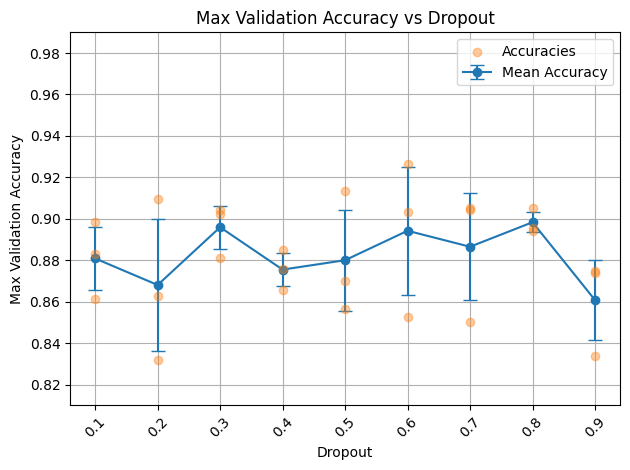

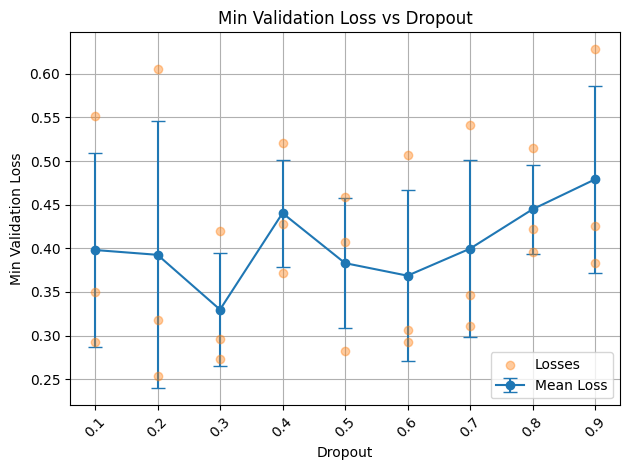

In [ ]:
# Load the search results from the pickle file
files = ['drive/MyDrive/lssds24/codelatam/v2_results/new_run/saved_search_results_dropout1_64_1e4_1e3.pkl',
         'drive/MyDrive/lssds24/codelatam/v2_results/new_run/saved_search_results_dropout2_64_1e4_1e3.pkl',
         'drive/MyDrive/lssds24/codelatam/v2_results/new_run/saved_search_results_dropout3_64_1e4_1e3.pkl']

search_results = []
for file in files:
    with open(file, 'rb') as f:
        search_results.append(pickle.load(f))

# Combine dictionaries
all_dicts = [search_results[0], search_results[1], search_results[2]]

# Initialize a dictionary to group accuracies by dropout
dp_accuracies = defaultdict(list)
dp_losses = defaultdict(list)

# Extract dropout and maximum validation accuracies
for d in all_dicts:
    for key, accuracies in d.items():
        # Extract weight decay value from the key
        dp = float(key.split('_')[3])
        # Changed this line to get the max of the val_acc list
        max_acc = max(accuracies['val_acc'])
        dp_accuracies[dp].append(max_acc)

        min_loss = min(accuracies['val_loss'])
        dp_losses[dp].append(min_loss)

# Compute mean and standard deviation for each WD
dp_values = []
mean_acc = []
std_acc = []
lower_error = []
upper_error = []
mid_acc = []

mean_loss = []
std_loss = []
lower_error_loss = []
upper_error_loss = []
mid_loss = []

for dp, accs in sorted(dp_accuracies.items()):
    dp_values.append(dp)
    mean_acc.append(np.mean(accs))
    std_acc.append(np.std(accs))
    mid = sum(accs) - max(accs) - min(accs)
    mid_acc.append(mid)
    lower_error.append(mid - min(accs))
    upper_error.append(max(accs) - mid)

for dp, loss in sorted(dp_losses.items()):
    mean_loss.append(np.mean(loss))
    std_loss.append(np.std(loss))
    mid_l = sum(loss) - max(loss) - min(loss)
    mid_loss.append(mid_l)
    lower_error_loss.append(mid_l - min(loss))
    upper_error_loss.append(max(loss) - mid_l)

# Plot
plt.errorbar(dp_values, mean_acc, yerr=std_acc, fmt='o-', capsize=5, label='Mean Accuracy')
plt.scatter(dp_values, mid_acc, label='Accuracies', marker='o', c='C1', zorder=90, alpha=0.4)
plt.scatter(dp_values, np.array(mid_acc)-np.array(lower_error), marker='o', c='C1', zorder=90, alpha=0.4)
plt.scatter(dp_values, np.array(mid_acc)+np.array(upper_error), marker='o', c='C1', zorder=90, alpha=0.4)


plt.xlabel('Dropout')
plt.ylim(0.81, 0.99)
plt.ylabel('Max Validation Accuracy')
plt.title('Max Validation Accuracy vs Dropout')
plt.grid(True)

# Set x-axis ticks and labels explicitly
plt.xticks(dp_values, labels=[f'{dp:.1f}' for dp in dp_values], rotation=45)

plt.legend()
plt.tight_layout()  # Adjust layout to accommodate rotated labels
plt.savefig('drive/MyDrive/lssds24/codelatam/v2_results/new_run/max_val_acc_vs_dropout_3splits_64_1e4_1e3.png', dpi=200, bbox_inches='tight')
plt.show()

# Plot
plt.errorbar(dp_values, mean_loss, yerr=std_loss, fmt='o-', capsize=5, label='Mean Loss')
plt.scatter(dp_values, mid_loss, label='Losses', marker='o', c='C1', zorder=90, alpha=0.4)
plt.scatter(dp_values, np.array(mid_loss)-np.array(lower_error_loss), marker='o', c='C1', zorder=90, alpha=0.4)
plt.scatter(dp_values, np.array(mid_loss)+np.array(upper_error_loss), marker='o', c='C1', zorder=90, alpha=0.4)

plt.xlabel('Dropout')
plt.ylabel('Min Validation Loss')
plt.title('Min Validation Loss vs Dropout')
plt.grid(True)

# Set x-axis ticks and labels explicitly
plt.xticks(dp_values, labels=[f'{dp:.1f}' for dp in dp_values], rotation=45)

plt.legend()
plt.tight_layout()  # Adjust layout to accommodate rotated labels
plt.savefig('drive/MyDrive/lssds24/codelatam/v2_results/new_run/min_val_loss_vs_dropout_3splits_64_1e4_1e3.png', dpi=200, bbox_inches='tight')
plt.show()

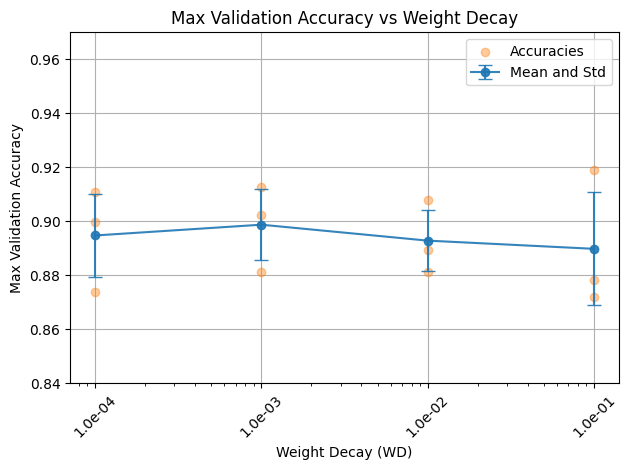

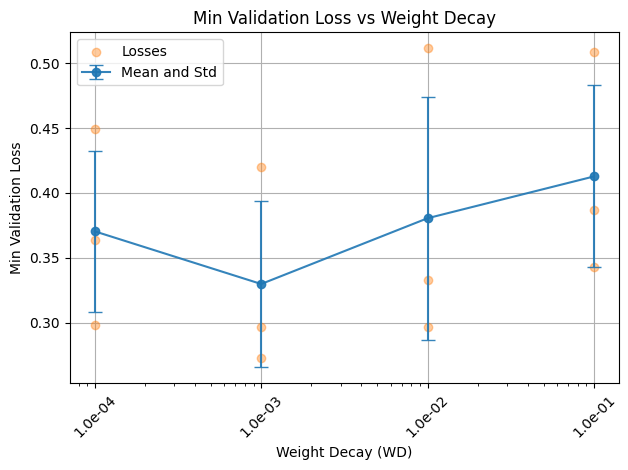

In [ ]:
# Load the search results from the pickle file
files = ['drive/MyDrive/lssds24/codelatam/v2_results/new_run/saved_search_results_wd1_64_1e4.pkl',
         'drive/MyDrive/lssds24/codelatam/v2_results/new_run/saved_search_results_wd2_64_1e4.pkl',
         'drive/MyDrive/lssds24/codelatam/v2_results/new_run/saved_search_results_wd3_64_1e4.pkl']

search_results = []
for file in files:
    with open(file, 'rb') as f:
        search_results.append(pickle.load(f))

# Combine dictionaries
all_dicts = [search_results[0], search_results[1], search_results[2]]

# Initialize a dictionary to group accuracies by WD
wd_accuracies = defaultdict(list)
wd_losses = defaultdict(list)

# Extract WD and maximum validation accuracies
for d in all_dicts:
    for key, accuracies in d.items():
        # Extract weight decay value from the key
        wd = float(key.split('_wd_')[1])
        # Changed this line to get the max of the val_acc list
        max_acc = max(accuracies['val_acc'])
        wd_accuracies[wd].append(max_acc)
        min_loss = min(accuracies['val_loss'])
        wd_losses[wd].append(min_loss)

# Compute mean and standard deviation for each WD
wd_values = []
mean_acc = []
std_acc = []
lower_error = []
upper_error = []
mid_acc = []

mean_loss = []
std_loss = []
lower_error_loss = []
upper_error_loss = []
mid_loss = []

for wd, accs in sorted(wd_accuracies.items()):
    wd_values.append(wd)
    mean_acc.append(np.mean(accs))
    std_acc.append(np.std(accs))
    mid = sum(accs) - max(accs) - min(accs)
    mid_acc.append(mid)
    lower_error.append(mid - min(accs))
    upper_error.append(max(accs) - mid)

for wd, loss in sorted(wd_losses.items()):
    mean_loss.append(np.mean(loss))
    std_loss.append(np.std(loss))
    mid_l = sum(loss) - max(loss) - min(loss)
    mid_loss.append(mid_l)
    lower_error_loss.append(mid_l - min(loss))
    upper_error_loss.append(max(loss) - mid_l)

plt.errorbar(wd_values, mean_acc, yerr=std_acc, fmt='o-', capsize=5, label='Mean and Std', alpha=0.9, zorder=100)
plt.scatter(wd_values, mid_acc, label='Accuracies', marker='o', c='C1', zorder=90, alpha=0.4)
plt.scatter(wd_values, np.array(mid_acc)-np.array(lower_error), marker='o', c='C1', zorder=90, alpha=0.4)
plt.scatter(wd_values, np.array(mid_acc)+np.array(upper_error), marker='o', c='C1', zorder=90, alpha=0.4)

plt.xlabel('Weight Decay (WD)')
plt.xscale('log')
plt.ylabel('Max Validation Accuracy')
plt.title('Max Validation Accuracy vs Weight Decay')
plt.grid(True)
plt.ylim(0.84, 0.97)
plt.xticks(wd_values, labels=[f'{wd:.1e}' for wd in wd_values], rotation=45)

plt.legend()
plt.tight_layout()
plt.savefig('drive/MyDrive/lssds24/codelatam/v2_results/new_run/max_val_acc_vs_wd_3splits_64_1e4.png', dpi=200, bbox_inches='tight')
plt.show()

plt.errorbar(wd_values, mean_loss, yerr=std_loss, fmt='o-', capsize=5, label='Mean and Std', alpha=0.9, zorder=100)
plt.scatter(wd_values, mid_loss, label='Losses', marker='o', c='C1', zorder=90, alpha=0.4)
plt.scatter(wd_values, np.array(mid_loss)-np.array(lower_error_loss), marker='o', c='C1', zorder=90, alpha=0.4)
plt.scatter(wd_values, np.array(mid_loss)+np.array(upper_error_loss), marker='o', c='C1', zorder=90, alpha=0.4)

plt.xlabel('Weight Decay (WD)')
plt.xscale('log')
plt.ylabel('Min Validation Loss')
plt.title('Min Validation Loss vs Weight Decay')
plt.grid(True)
#plt.ylim(0.84, 0.97)
plt.xticks(wd_values, labels=[f'{wd:.1e}' for wd in wd_values], rotation=45)

plt.legend()
plt.tight_layout()
plt.savefig('drive/MyDrive/lssds24/codelatam/v2_results/new_run/min_loss_vs_wd_3splits_64_1e4.png', dpi=200, bbox_inches='tight')
plt.show()


## Train results

In [ ]:
# Load the plotting data of the last run from the pickle file
with open('drive/MyDrive/lssds24/codelatam/v2_results/new_run/plot_results_split4_64_1e4_1e3_03.pkl', 'rb') as f:
    plots_dict = pickle.load(f)

for key, values in plots_dict.items():
  t_loss, t_acc, t_f1, v_loss, v_acc, v_f1 = values

### Learning curves

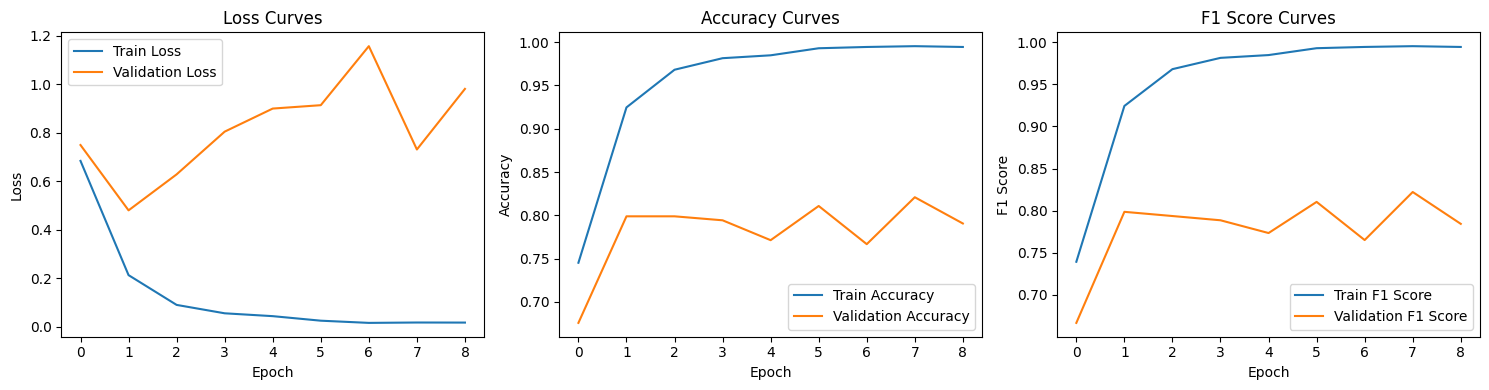

In [ ]:
# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot Loss
axes[0].plot(t_loss, label='Train Loss')
axes[0].plot(v_loss, label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Curves')
axes[0].legend()

# Plot Accuracy
axes[1].plot(t_acc, label='Train Accuracy')
axes[1].plot(v_acc, label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Curves')
axes[1].legend()

# Plot F1 Score
axes[2].plot(t_f1, label='Train F1 Score')
axes[2].plot(v_f1, label='Validation F1 Score')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score Curves')
axes[2].legend()

# Adjust spacing between subplots
plt.tight_layout()
plt.savefig('drive/MyDrive/lssds24/codelatam/v2_results/new_run/training_split4_64_1e4_1e3_03.png', dpi=200, bbox_inches='tight')
# Show the plot
plt.show()

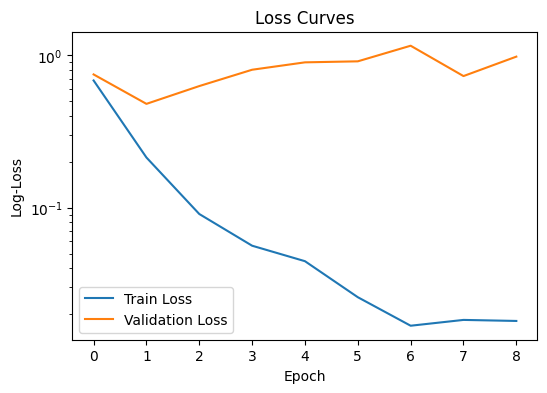

In [ ]:
# Log loss
fig, axes = plt.subplots(figsize=(6, 4))

# Plot Loss
axes.plot(t_loss, label='Train Loss')
axes.plot(v_loss, label='Validation Loss')
axes.set_yscale('log')
axes.set_xlabel('Epoch')
axes.set_ylabel('Log-Loss')
axes.set_title('Loss Curves')
axes.legend()
plt.savefig('drive/MyDrive/lssds24/codelatam/v2_results/new_run/log-loss_split4_64_1e4_1e3_03.png', dpi=200, bbox_inches='tight')

### Inference

In [ ]:
# load best_model_**.pth, set to eval_mode

# model.load_state_dict(torch.load('drive/MyDrive/lssds24/codelatam/v2_results/new_run/best_model_split4_64_1e4_1e3_03.pth')['model'])
# classifier.load_state_dict(torch.load('drive/MyDrive/lssds24/codelatam/v2_results/new_run/best_model_split4_64_1e4_1e3_03.pth')['classifier'])
model.eval()
classifier.eval()

outputs = []
with torch.no_grad():
    for batch_data in test_dataloader:
        outputs.append(predict_step(batch_data, model, processor, classifier, device))

In [ ]:
outputs[0].keys()

dict_keys(['id', 'y_pred', 'y_pred_prob', 'y_true'])

In [ ]:
keys = outputs[0].keys()
outputs_dict = {key: [] for key in keys}

for i in range(len(outputs)):
    for key in keys:
        outputs_dict[key].append(outputs[i][key])

outputs_dict = {key: np.concatenate(values) for key, values in outputs_dict.items()}

{'id': array(['sn2004dt_0_0_26.4_246', 'sn98bu_0_0_42.1_1152',
        'sn95D_0_0_33.047_2348', 'sn2004dt_0_0_-1.0_232',
        'sn2006D_0_0_-1.4_2119', 'sn2006bt_0_0_5.7_1830',
        'sn98bu_0_0_43.1_1153', 'sn98bu_0_0_33.2_1143',
        'sn98bu_0_0_13.2_1136', 'sn2006bt_0_0_-0.1_1824',
        'sn2001bf_0_0_64.5_743', 'sn1997dt_0_0_-8.7_1584',
        'sn2005eu_0_0_8.3_654', 'sn2003kf_0_0_-7.4_685',
        'sn98bu_0_0_-1.7_1129', 'sn1997dt_0_0_-9.7_1583',
        'sn95D_0_0_69.6_1127', 'sn2003kf_0_0_53.1_703',
        'sn2001N_0_0_11.5_1479', 'sn2003kf_0_0_-3.4_687',
        'sn2004dt_0_0_48.6_251', 'sn2004dt_0_0_-5.6_227',
        'sn2000E_0_0_120.3_1019', 'sn2001bf_0_0_58.8_742',
        'sn98bu_0_0_29.2_1139', 'sn2006mo_0_0_5.2_482',
        'sn06N_0_0_-1.936_1277', 'sn2004dt_0_0_346.8_258',
        'sn01en_0_0_35.641_1414', 'sn98bu_0_0_-2.8_1128',
        'sn98bu_0_0_57.1_1155', 'sn2003kf_0_0_397.8_707',
        'sn1997dt_0_0_-7.7_1585', 'sn95D_0_0_8.1_1120',
        'sn2004

In [ ]:
outputs_dict['y_true'] = [inv_dict_mapping_classes[val] for val in outputs_dict['y_true']]
outputs_dict['y_pred'] = [inv_dict_mapping_classes[val] for val in outputs_dict['y_pred']]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(outputs_dict['y_true'], outputs_dict['y_pred'], digits=4))

              precision    recall  f1-score   support

     Ia-norm     0.8912    0.9383    0.9142       227
      Ia-pec     0.8479    0.8479    0.8479       217
      Others     0.8873    0.8400    0.8630       225

    accuracy                         0.8759       669
   macro avg     0.8755    0.8754    0.8750       669
weighted avg     0.8759    0.8759    0.8755       669



### Confusion matrix

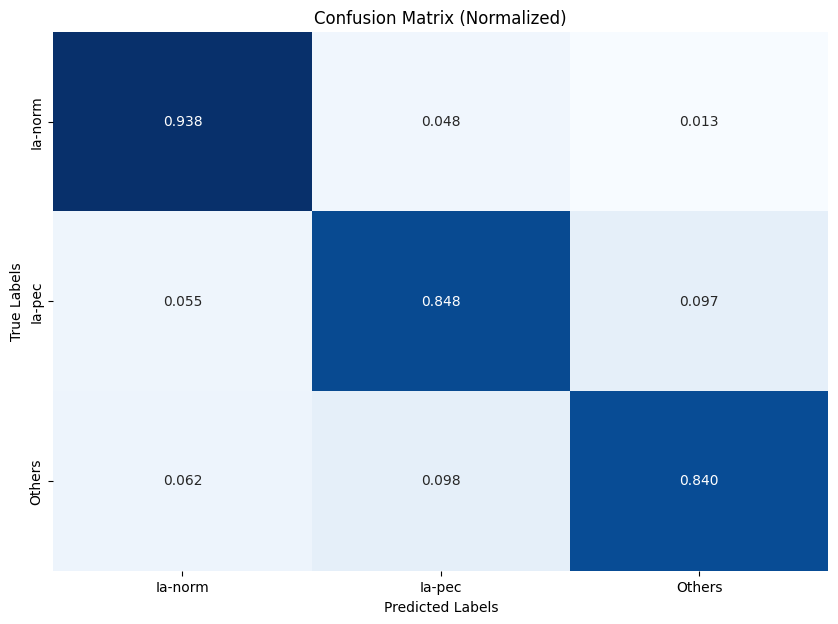

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(outputs_dict['y_true'], outputs_dict['y_pred'])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = inv_dict_mapping_classes.values()

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Normalized)')
# plt.savefig('drive/MyDrive/lssds24/codelatam/v2_results/new_run/confusion_matrix_split4_64_1e4_1e3_03.png', dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
subtype_mapping = {0: 'Ia-norm',
                   1: 'Ia-91T',
                   2: 'Ia-91bg',
                   3: 'Ia-csm',
                   4: 'Iax',
                   5: 'Ia-pec',
                   6: 'Ib-norm',
                   7: 'Ibn',
                   8: 'IIb',
                   9: 'Ib-pec',
                   10: 'Ic-norm',
                   11: 'Ic-broad',
                   12: 'Ic-pec',
                   13: 'IIP',
                   14: 'IIL',
                   15: 'IIn',
                   16: 'II-pec'}

### Missclassified images

In [ ]:
# identify all missclassified Images
missclassified_ia_norm_as_ia_pec = []
missclassified_ia_norm_as_others = []
missclassified_ia_pec_as_ia_norm = []
missclassified_ia_pec_as_others = []
missclassified_others_as_ia_norm = []
missclassified_others_as_ia_pec = []

for i in range(len(outputs_dict['y_true'])):
  if outputs_dict['y_true'][i] == 'Ia-norm' and outputs_dict['y_pred'][i] == 'Ia-pec':
    missclassified_ia_norm_as_ia_pec.append(outputs_dict['id'][i])
  elif outputs_dict['y_true'][i] == 'Ia-norm' and outputs_dict['y_pred'][i] == 'Others':
    missclassified_ia_norm_as_others.append(outputs_dict['id'][i])
  elif outputs_dict['y_true'][i] == 'Ia-pec' and outputs_dict['y_pred'][i] == 'Ia-norm':
    missclassified_ia_pec_as_ia_norm.append(outputs_dict['id'][i])
  elif outputs_dict['y_true'][i] == 'Ia-pec' and outputs_dict['y_pred'][i] == 'Others':
    missclassified_ia_pec_as_others.append(outputs_dict['id'][i])
  elif outputs_dict['y_true'][i] == 'Others' and outputs_dict['y_pred'][i] == 'Ia-norm':
    missclassified_others_as_ia_norm.append(outputs_dict['id'][i])
  elif outputs_dict['y_true'][i] == 'Others' and outputs_dict['y_pred'][i] == 'Ia-pec':
    missclassified_others_as_ia_pec.append(outputs_dict['id'][i])

print("Missclassified Ia-norm as Ia-pec images:")
print(missclassified_ia_norm_as_ia_pec)

print("Missclassified Ia-norm as Others images:")
print(missclassified_ia_norm_as_others)

Missclassified Ia-norm as Ia-pec images:
[np.str_('sn2004dt_0_0_26.4_246'), np.str_('sn2003kf_0_0_397.8_707'), np.str_('sn2004dt_0_0_-3.0_230'), np.str_('sn2006bt_0_0_32.9_1832'), np.str_('sn06bu_0_0_4.238_2150'), np.str_('sn2001N_0_0_30.0_1481'), np.str_('sn2005eu_0_0_-9.0_651'), np.str_('sn2006bt_0_0_53.3_1833'), np.str_('sn2000E_0_0_7.5_1016'), np.str_('sn2006D_0_0_-5.3_2118'), np.str_('sn2006D_0_0_-7.3_2117')]
Missclassified Ia-norm as Others images:
[np.str_('sn2004dt_0_0_346.8_258'), np.str_('sn2004dt_0_0_-9.9_220'), np.str_('sn2004dt_0_0_109.3_256')]


In [ ]:
# make the plot in a nxn grid
def plot_missclassified_images(image_ids, root_dir, subfolder, prediction, ncols=3):
  """Plots missclassified images from a list of image IDs in a grid.

  Args:
      image_ids: A list of image IDs.
      root_dir: The root directory where the images are stored.
      subfolder: The subfolder within the root directory where the images are stored.
      ncols: Number of columns in the grid.
  """

  nrows = (len(image_ids) + ncols - 1) // ncols  # Calculate the number of rows needed
  fig, axes = plt.subplots(nrows, ncols, figsize=(15, 3 * nrows))

  # Check if axes is 1-dimensional and convert to 2-dimensional if necessary
  if nrows == 1 or ncols == 1:
    axes = axes.reshape(nrows, ncols) # added this line to reshape axes to 2d if it's 1d

  for i, image_id in enumerate(image_ids):
    image_path = os.path.join(root_dir, subfolder, image_id + ".png")
    if os.path.exists(image_path):
      img = plt.imread(image_path)
      row = i // ncols
      col = i % ncols
      axes[row, col].imshow(img)
      axes[row, col].set_title(f"Missclassified Image: {image_id}\n Label: {inv_dict_mapping_classes[maping(int(image_id.split('_')[1]))]}, Subtype: {subtype_mapping[int(image_id.split('_')[1])]} \n Prediction: {prediction}")
      axes[row, col].axis('off')  # Turn off axis labels and ticks
  # Remove any empty subplots
  for i in range(len(image_ids), nrows * ncols):
    row = i // ncols
    col = i % ncols
    fig.delaxes(axes[row, col])

  plt.tight_layout()
  plt.show()

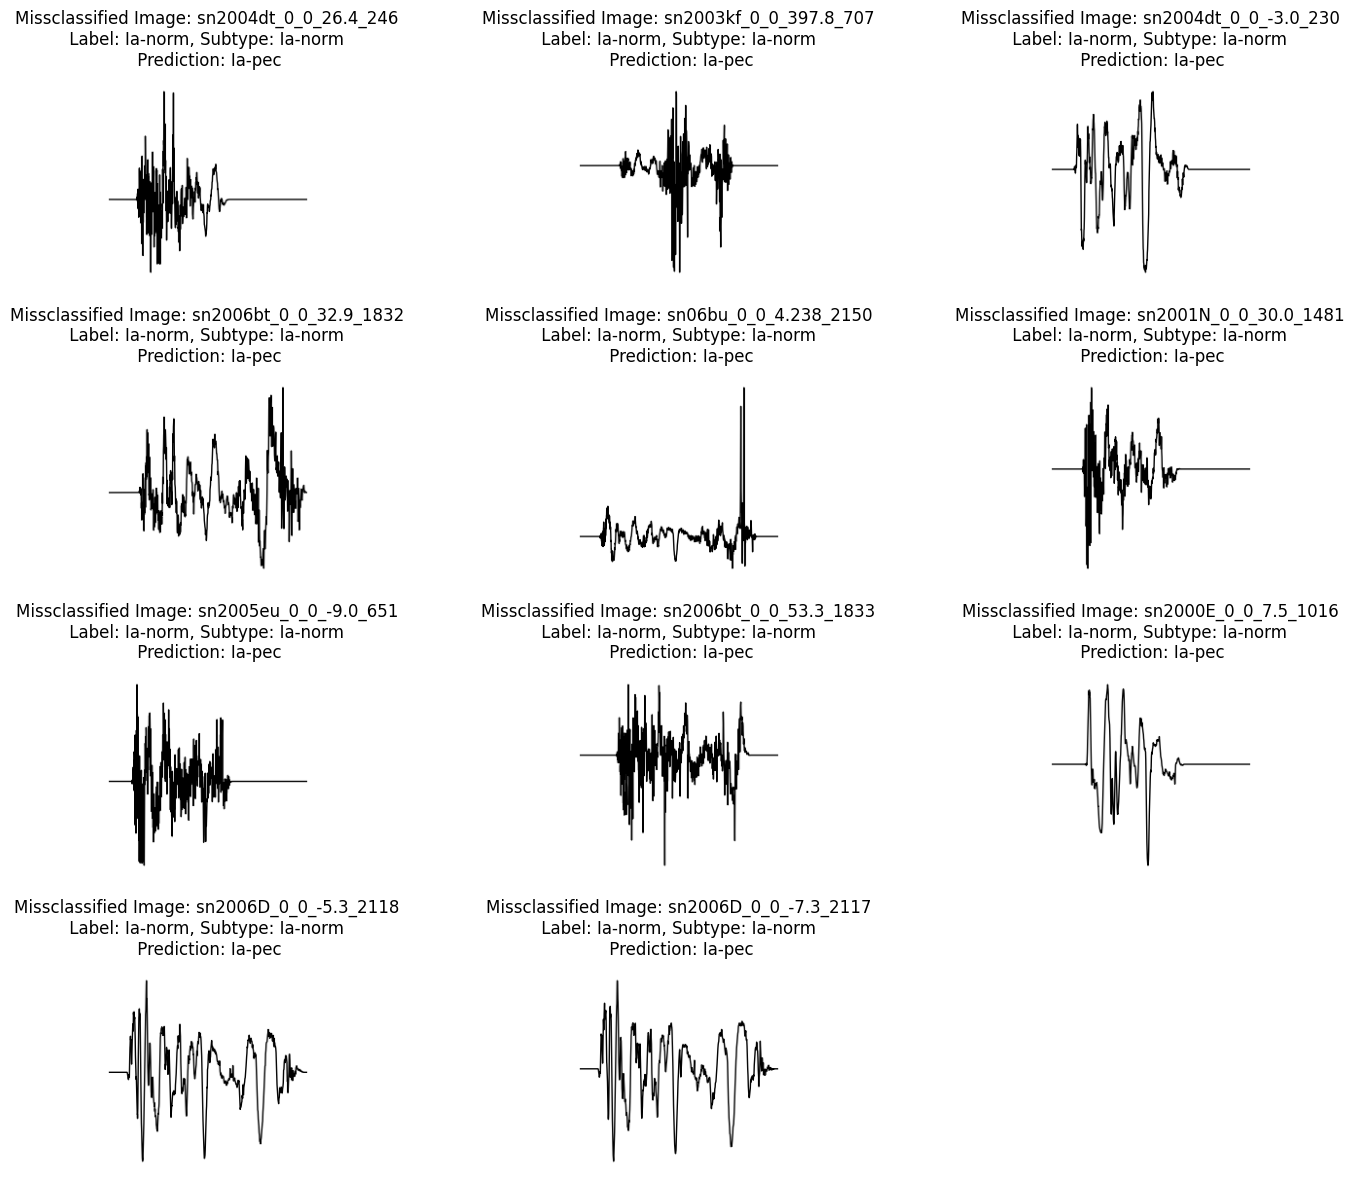

In [ ]:
# Plot the Ia-norm missclassified as ia-pec
plot_missclassified_images(missclassified_ia_norm_as_ia_pec, root_dir, "0", prediction='Ia-pec', ncols=3)

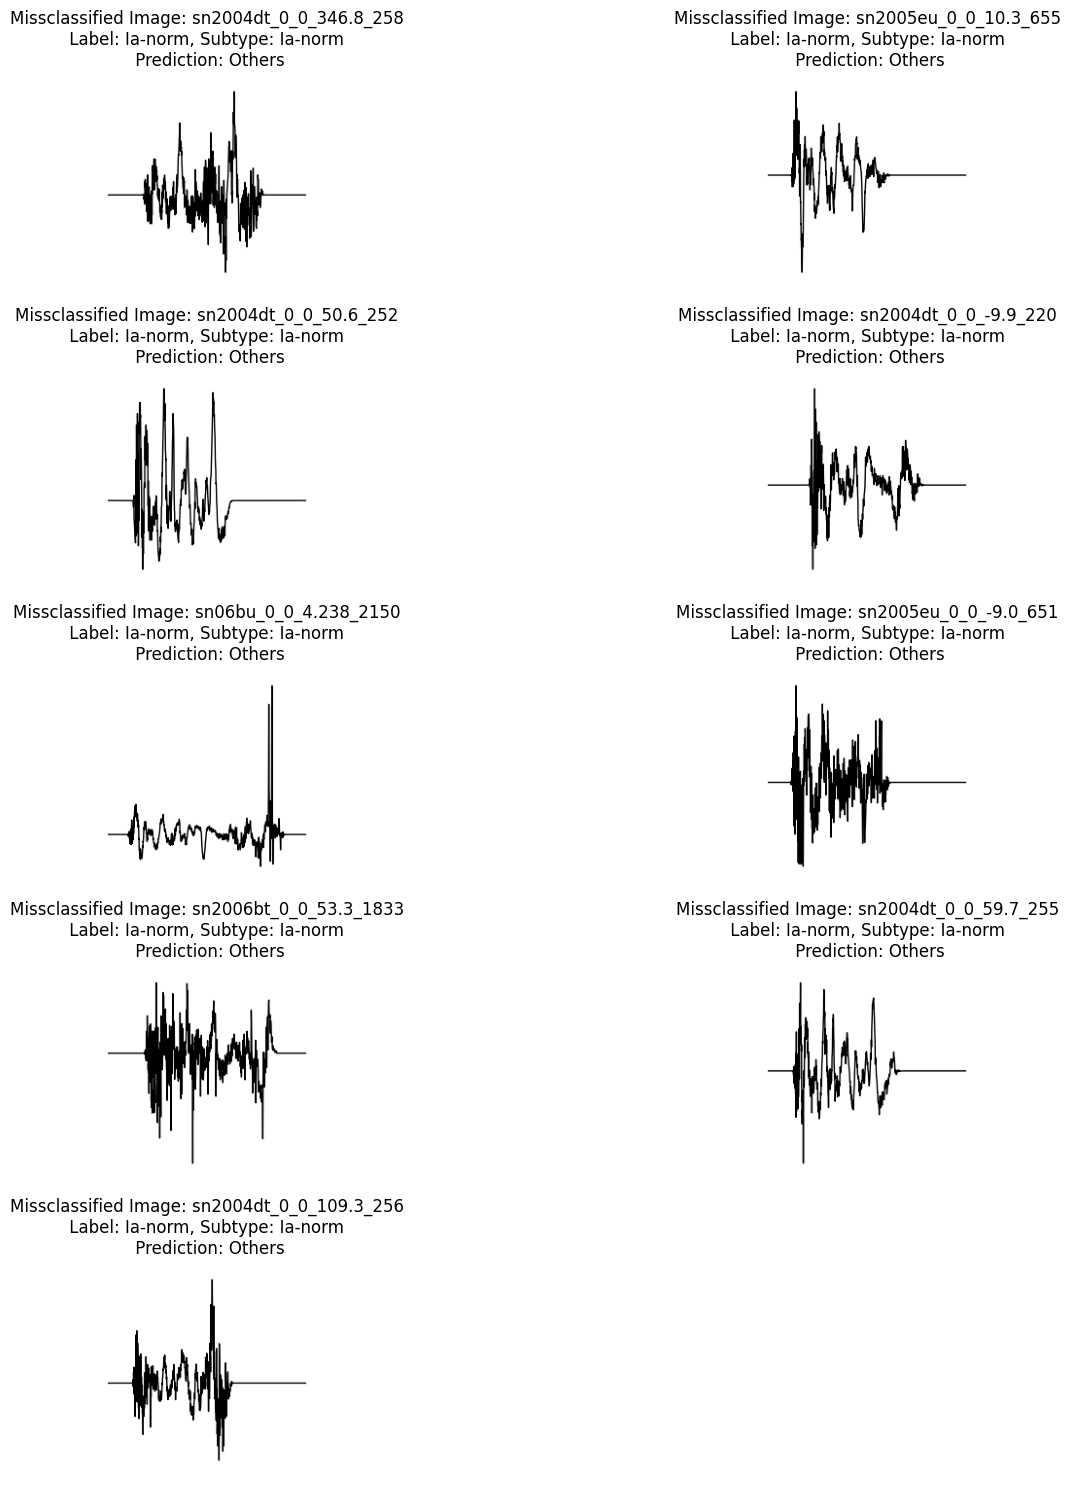

In [ ]:
# Plot the Ia-norm missclassified as other
plot_missclassified_images(missclassified_ia_norm_as_others, root_dir, "0", prediction='Others', ncols=2)

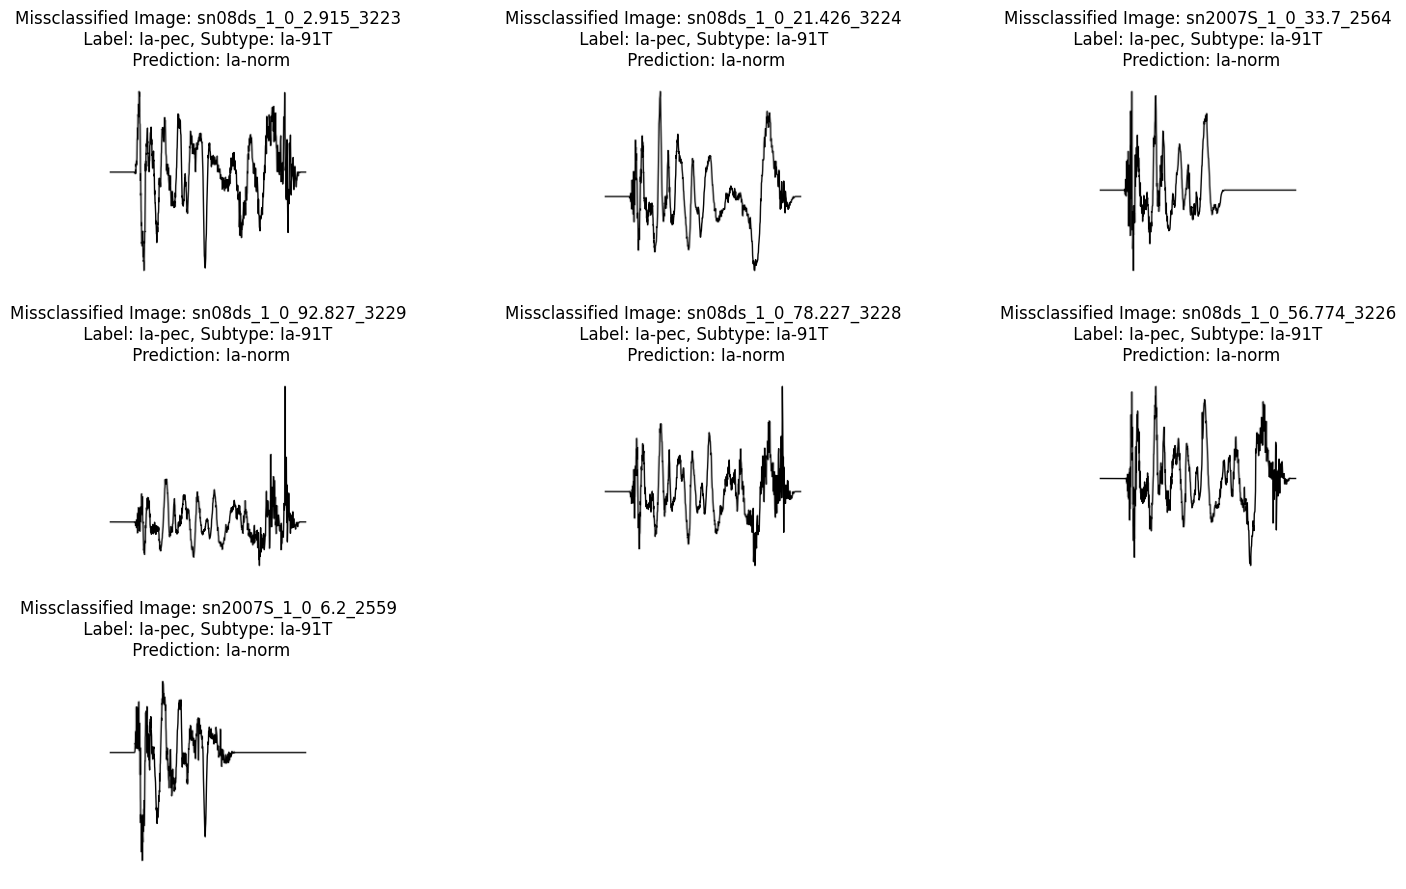

In [ ]:
#plot the Ia-pec missclassified as Ia-norm
plot_missclassified_images(missclassified_ia_pec_as_ia_norm, root_dir, "1", prediction='Ia-norm', ncols=3)

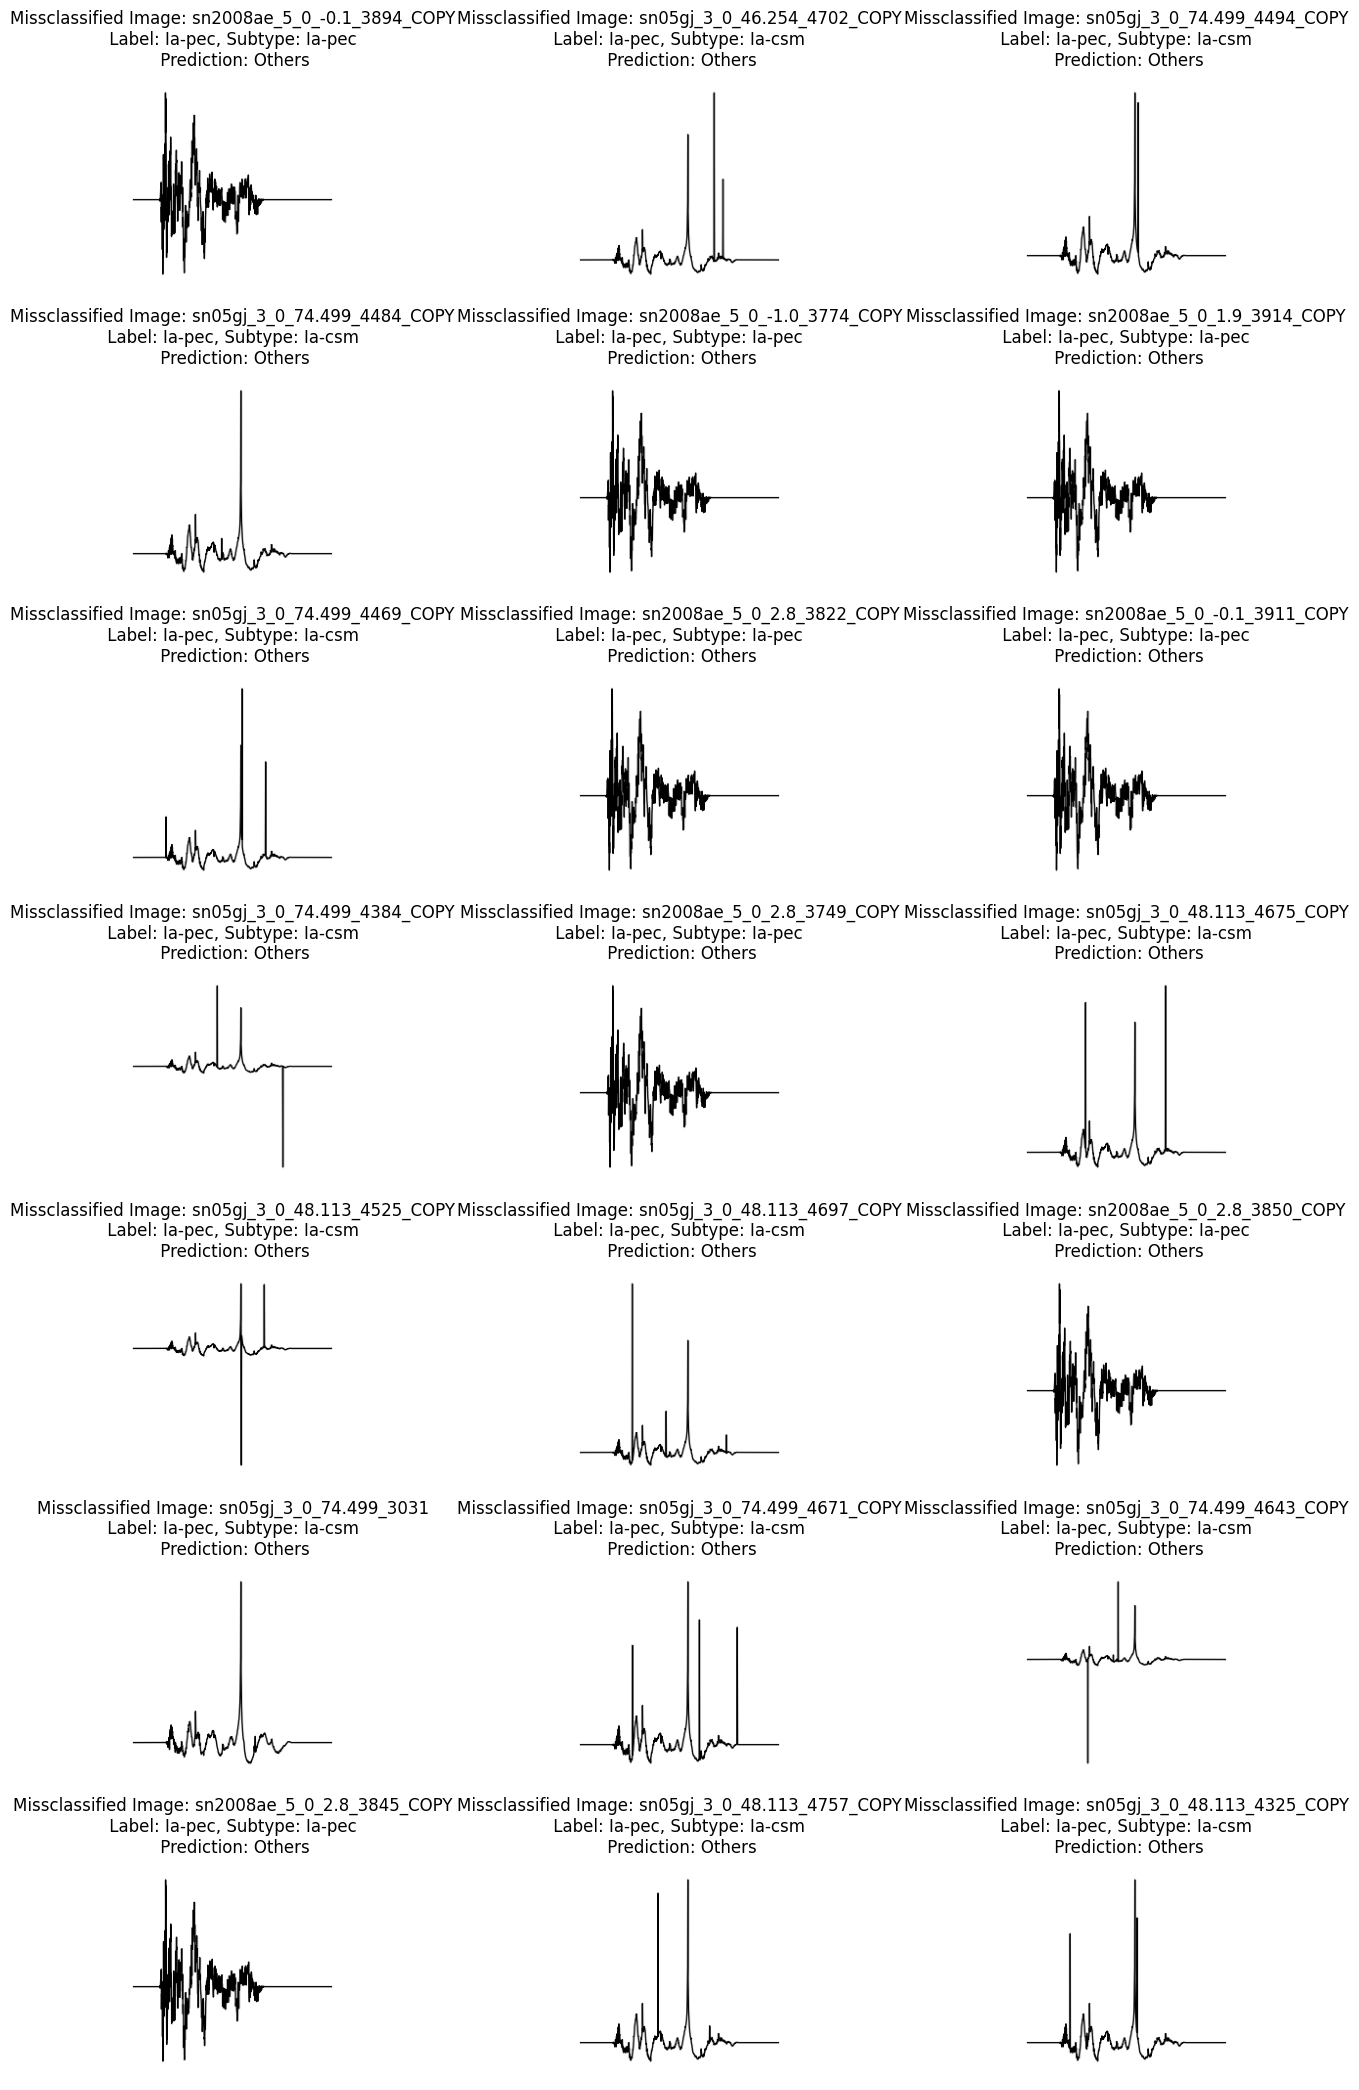

In [ ]:
plot_missclassified_images(missclassified_ia_pec_as_others, root_dir, "1", prediction='Others', ncols=3)

In [ ]:
# check how many Ia-91T are in test set, also save phases
Ia91t_in_test = []
phases = []
for i in splits['1']['test']:
  a = i.split('_')[1]
  if a == '1':
    Ia91t_in_test.append(i.split('_')[0])
    phases.append(float(i.split('_')[3]))
print(list(set(Ia91t_in_test)))
print('Ia-91T in test set:', len(Ia91t_in_test))
print('Ia-91T missclassified:', len(missclassified_ia_pec_as_ia_norm))

['sn08ds', 'sn2006cz', 'sn1991T', 'sn2007S']
Ia-91T in test set: 44
Ia-91T missclassified: 7


In [ ]:
miss_phases = []
for image_name in missclassified_ia_pec_as_ia_norm:
  miss_phases.append(float(image_name.split('_')[3]))

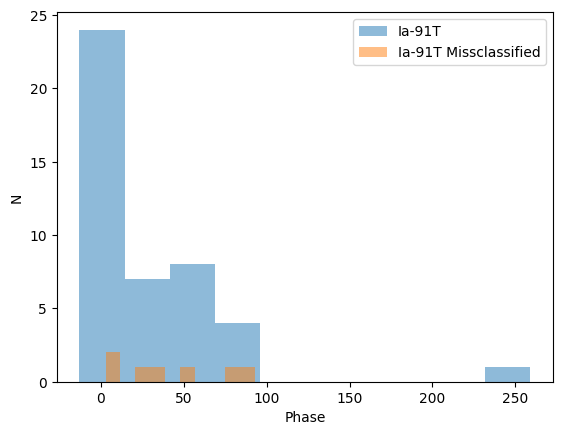

In [ ]:
plt.hist(phases, alpha=0.5, label='Ia-91T')
plt.hist(miss_phases, alpha=0.5, label='Ia-91T Missclassified')
plt.xlabel('Phase')
plt.ylabel('N')
plt.legend()
plt.savefig('drive/MyDrive/lssds24/codelatam/v2_results/new_run/Ia-91T-phases-histogram.png', dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
# I want to check if the Ia-norm's missclassified as Ia-pec are generally older SNs
# Need to get the year of the SN and plot an histogram of

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/juanserrano90/codelatam/refs/heads/main/Data/Redshift/sn_redshift.csv')

In [ ]:
years_miss = []
for image_name in missclassified_ia_norm_as_ia_pec:
  name = image_name.split('_')[0].lower()
  year = df[df['old_name'] == name]['year'].values[0]
  years_miss.append(year)
print(len(years_miss), len(missclassified_ia_norm_as_ia_pec))

years_ianorm = []
unique_ianorms = []
for image_name in image_lists['0']:
  name = image_name.split('_')[0].lower()
  if name not in unique_ianorms:
    unique_ianorms.append(name)
    year = df[df['old_name'] == name]['year'].values[0]
    years_ianorm.append(year)
print(len(years_ianorm), len(image_lists['0']))
print(len(unique_ianorms))

In [ ]:
print(np.array(years_ianorm).min(), np.array(years_ianorm).max())

In [ ]:
# Calculate medians and counts
median_ianorm = np.median(years_ianorm)
median_missclassified = np.median(years_miss)
count_ianorm = len(years_ianorm)
count_missclassified = len(years_miss)

# Print or use the results as needed
print(f"Median year for Ia-norm: {median_ianorm}")
print(f"Median year for missclassified Ia-norm: {median_missclassified}")
print(f"Total count of Ia-norm: {count_ianorm}")
print(f"Total count of missclassified Ia-norm: {count_missclassified}")

# Example of adding the medians to a plot (assuming the plot code from your example)

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(years_ianorm, alpha=0.5, bins=np.arange(1981, 2010), align='left', edgecolor='black', label='Ia-norm')
ax.hist(years_miss, alpha=0.9, bins=np.arange(1981, 2010), align='left', edgecolor='black', label='Ia-norm Missclassified as Ia-pec')
ax.axvline(median_ianorm, color='blue', linestyle='dashed', linewidth=1, label=f'Ia-norm Median: {median_ianorm:.2f}')
ax.axvline(median_missclassified, color='red', linestyle='dashed', linewidth=1, label=f'Missclassified Median: {median_missclassified:.2f}')


plt.xlabel('Year')
plt.xticks(np.arange(1981, 2009), rotation=70)
plt.yticks(np.arange(0, 51, 5))
plt.ylabel('N')
plt.title('Year of discovery of Ia-norm SNs')
plt.legend()
plt.grid(True, alpha=0.4)
plt.savefig('drive/MyDrive/lssds24/codelatam/v2_results/new_run/Ia-norm-missclassidief-years-histogram_with_medians.png', dpi=200, bbox_inches='tight')
plt.show()